# post-processing

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %matplotlib widget

In [2]:
import pickle
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=12) 
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogFormatter 
import seaborn as sns
# from datetime import datetime
import datetime as dt
import datetime
from tqdm.notebook import tqdm
# import pillow
# import geopandas as gpd
from textwrap import wrap
import shapefile, fiona, shapely
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point


from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import collections as pltc

from IPython.display import HTML
from matplotlib import animation

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import sys
sys.path.append("/global/cfs/cdirs/m1800/pin/github/watershed-workflow")
sys.path.append("/global/u2/p/pshuai/.conda/envs/geo/lib/python3.9/site-packages")
import workflow

In [5]:
import modvis
import modvis.ATSutils as utils 
import modvis.ats_xdmf as xdmf
import modvis.transect_data as transect_data
import modvis.plot_vis_file as pv
import modvis.general_plots as gp
import modvis.utils as ut 
import modvis.colors as mcolors

In [6]:
imodel = "transient_cal"
ires = "50m"
# icase = "res250m_tck0.0m"
# icase = "res250m_tck0.25m_k1.0md"
icase = f"res{ires}_tck0.5m_k1.0md"


model_time_unit='d'
# imodel = "sensitivity_analysis_400"
# icase = "forward.10" # qetsc-mi forwrd run
# model = "model_250m-c64/spinup-rs150m-gauss3-rst"
work_dir = f"/global/cfs/cdirs/m1800/pin/github/ARW/"
model_dir = f"/pscratch/sd/p/pshuai/ARW/model/runs/{imodel}-{icase}/"
data_dir = work_dir + "data/"
figure_dir = work_dir + "figures/"
# data_dir = "/global/project/projectdirs/m1800/pin/yakima/data/"
# fig_dir = "/global/project/projectdirs/m1800/pin/yakima/figures/"

# prefix = "ats_vis"
# subsurface_mesh = f"{prefix}_mesh.h5"
# surface_mesh = f"{prefix}_surface_mesh.h5"
# subsurface_h5 = f"{prefix}_data.h5"
# surface_h5 = f"{prefix}_surface_data.h5"
# snow_mesh = f"{prefix}_snow_mesh.h5"

# fname_snow_h5 = model_dir + f"{prefix}_snow_data.h5"
# fname_snow_mesh = model_dir + f"{prefix}_snow_mesh.h5"
# fname_subsurface_h5 = model_dir + f"{prefix}_data.h5"
# fname_surface_h5 = model_dir + f"{prefix}_surface_data.h5"
# fname_surface_mesh = model_dir + f"{prefix}_surface_mesh.h5"
# fname_mesh = model_dir + f"{prefix}_mesh.h5"


# fname_combo_subsurface_h5 =  f"{prefix}_data-combo.h5"
# fname_combo_surface_h5 =  f"{prefix}_surface_data-combo.h5"
# fname_combo_snow_h5 =  f"{prefix}_snow_data-combo.h5"
# fname_subbasin = data_dir + "subbasin/subbasin_epsg2856.shp"
out_dir = data_dir + f"WW_outputs/"
data_dir = work_dir + "data/"
riverbed_dir = work_dir + "data/postprocessed/riverbed_study/"
fname_exchange_flux = riverbed_dir + f"{icase}-exchange_flux.csv"
fname_ET = riverbed_dir + f"{icase}-ET.csv"
fname_E = riverbed_dir + f"{icase}-E.csv"
fname_T = riverbed_dir + f"{icase}-T.csv"
# fname_water_balance = out_dir + "ARW_water_balance.csv"

# fname_exchange_flux_base = "/global/project/projectdirs/m1800/pin/yakima/output/ARW_250m-c128-riverbed/ARW_exchange_flux.csv"

fname_water_balance = data_dir + f"postprocessed/riverbed_study/{icase}-wb.csv"
fname_nexss = data_dir + "NEXSS/nhd_am_stream_nexss_monthly_annual_lateral_vertical_exchangeflux_log10_m_s.csv"
# fname_2Dmesh = f'../data/WW_outputs/{watershed_name}_riverbed-2Dmesh-{meshRes}.p'

fname_river_idx = out_dir + f"American_riverbed-2Dmesh-{ires}.p"
# fname_subbasin = data_dir + "NHDPlus_subbasin/subbasins.shp"
# fname_river_idx = "./data/preprocessed/American_river_idx-250m-riverbed.txt"
fname_river_shp = data_dir + "preprocessed/america_flowlines_nhdplusVAA-EPSG2856.shp"

fname_modis_snowcover = data_dir + "MODIS/ARW_MODIS_snowcover_2000-2021.csv"


In [7]:
def var_across_riverbed(surface_vis, varname, river_idx, weighted_mean=False, total_volume=False):
    """get surface variable across riverbed"""
    
    data = surface_vis.getArray(varname)
    area = surface_vis.volume
    times = surface_vis.times
    t = utils.rmLeapDays(times)

    if "transpiration" in varname or "evaporation" in varname:
        data = data*86400*1000 # mol/s to mm/d
    elif "flux" in varname:
        data = data/ 55500*86400/area*1000 # mol/s to mm/d

    sub_data = data[:, river_idx]
    sub_area = area[river_idx]
    
    sub_data_df = pd.DataFrame(sub_data)
    sub_data_df['datetime'] = t
    sub_data_df.set_index('datetime', inplace = True)
    
    if weighted_mean and "flux" in varname:
        mean = np.average(sub_data, axis = 1, weights=sub_area)
        sub_data_df['average [mm/d]'] = mean
        
    if total_volume and "flux" in varname:
        total = np.dot(sub_data/1000, sub_area)
        sub_data_df['sum [m^3/d]'] = total
    return sub_data_df, sub_data, sub_area

# import vis data

## import surface mesh

In [8]:
if icase == "res250m_tck0.0m":
    surface_vis = xdmf.VisFile(model_dir, domain='surface', load_mesh=True, model_time_unit='d',
                               ats_version=1.2)
else:
    surface_vis = xdmf.VisFile(model_dir, domain='surface', load_mesh=True, model_time_unit='yr',
                              ats_version=1.2)

In [9]:
t = pv.get_time(surface_vis)

In [10]:
t

array([datetime.datetime(2013, 10, 1, 0, 0),
       datetime.datetime(2013, 10, 2, 0, 0),
       datetime.datetime(2013, 10, 3, 0, 0), ...,
       datetime.datetime(2016, 9, 29, 0, 0),
       datetime.datetime(2016, 9, 30, 0, 0),
       datetime.datetime(2016, 10, 1, 0, 0)], dtype=object)

In [11]:
list(surface_vis.d)

['surface-air_temperature.cell.0',
 'surface-albedos.cell.0',
 'surface-albedos.cell.1',
 'surface-area_fractions.cell.0',
 'surface-area_fractions.cell.1',
 'surface-aspect.cell.0',
 'surface-cell_volume.cell.0',
 'surface-elevation.cell.0',
 'surface-emissivities.cell.0',
 'surface-emissivities.cell.1',
 'surface-evaporation.cell.0',
 'surface-incident_shortwave_radiation.cell.0',
 'surface-incoming_longwave_radiation.cell.0',
 'surface-incoming_shortwave_radiation.cell.0',
 'surface-manning_coefficient.cell.0',
 'surface-mass_density_liquid.cell.0',
 'surface-molar_density_liquid.cell.0',
 'surface-overland_conductivity.cell.0',
 'surface-ponded_depth.cell.0',
 'surface-ponded_depth_bar.cell.0',
 'surface-potential_evaporation.cell.0',
 'surface-precipitation_rain.cell.0',
 'surface-pres_elev.cell.0',
 'surface-pressure.cell.0',
 'surface-radiation_balance.cell.0',
 'surface-relative_humidity.cell.0',
 'surface-relative_permeability.cell.0',
 'surface-slope_magnitude.cell.0',
 'surf

# plot exchange flux

2023-09-12 20:12:31,908 - root - INFO: No unit convertion.


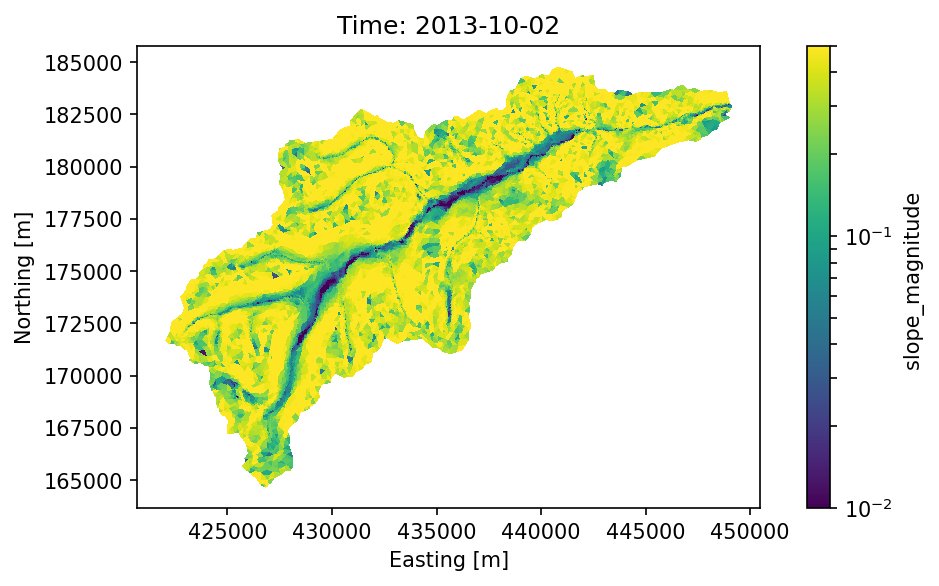

In [16]:
fig, ax, _ = pv.plot_surface_data(surface_vis,
                               var_name="slope_magnitude", colorbar = True,
                                # cmap = '',
#                                subset = True, subset_idx = river_idx,
                                  vmin = 0.01, vmax=0.5,
                               title = True, log = True, time_slice=1)

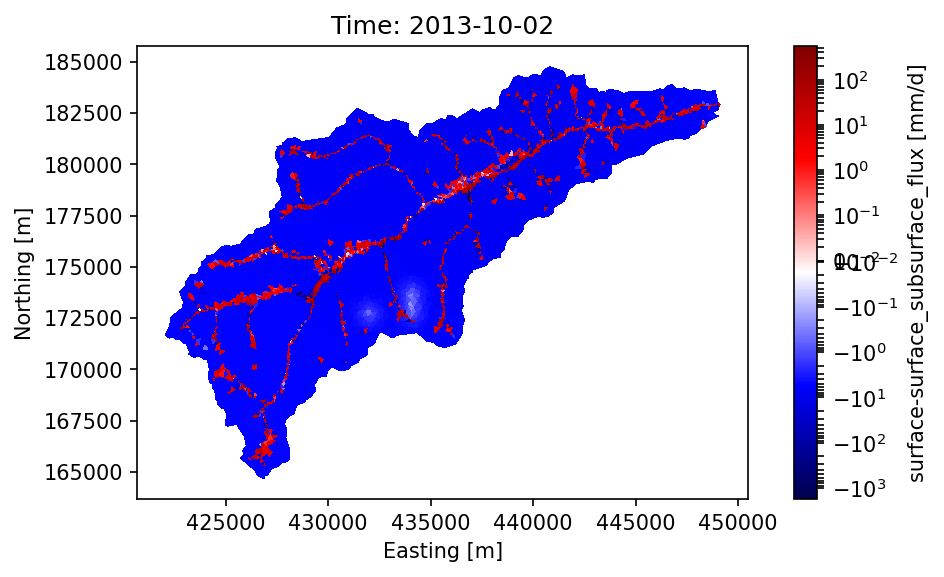

In [138]:
fig, ax, _ = pv.plot_surface_data(surface_vis,
                               var_name="surface-surface_subsurface_flux", colorbar = True,
                                cmap = 'seismic',
#                                subset = True, subset_idx = river_idx,
                               title = True, log = True, time_slice=1)

## plot riverbed exchange flux

In [12]:
with open(fname_river_idx, "rb") as f:
    mesh_points2, mesh_tris, areas, distances, river_idx = pickle.load(f)

In [13]:
# river_idx = np.loadtxt(out_dir + "American_river_idx-250m.txt", dtype=bool)

In [14]:
surface_vertex_xyz = surface_vis.vertex_xyz
surface_vertex_xy = surface_vertex_xyz[:, 0:2]
river_cells = mesh_tris[river_idx]

surface_conn = surface_vis.conn
triangles = surface_conn[:, -3:]

Do the mapping because river ids sequence does not match in the mesh vs in the Visdump file.

In [15]:
def find_row_mapping(A, B):
    """
    Find mapping between two numpy array. The two arrays have same shape (no duplicates!), 
    but one array has been shuffled compared to the other one. 
    See SOF post:https://stackoverflow.com/a/18927811/9319184

    Arguments:
        A, B:   n-dimensional arrays with same shape and dtype
    Returns:
        mapping:    vector of indices into the rows of A so that B[mapping] == A
    """
    mapping = []
    for row in A:
        idx = np.where(np.all(B==row, axis=1))[0]
        assert len(idx)==1
        mapping.append(idx[0])

    return mapping

In [16]:
mapping = find_row_mapping(mesh_points2, surface_vertex_xy)

In [17]:
def f(x):
    return mapping[x]

def map_func2array(f, arr):
    """mapping function to numpy array. Apply function to each element of array."""
    #vectorize function
    vf = np.vectorize(f)
    #map to array
    return vf(arr)

In [18]:
new_river_cells = map_func2array(f, river_cells)

# m = find_row_mapping(new_river_cells, triangles)

new_river_idx = []
for tri in triangles:
    idx = np.where(np.all(new_river_cells==tri, axis=1))[0]
    if len(idx) == 1:
        new_river_idx.append(True)
    elif len(idx) == 0:
        new_river_idx.append(False)
    else:
        raise

### plot riverbed

In [22]:
def plot_riverbed(source, vertex_xyz, triangles, rivers=None, dist_to_river = 200, plot = True):
    """find riverbed region given river shapefile or index."""

    try:
        if rivers is None:
            with fiona.open(source, 'r') as fid:
                profile = fid.profile
                shps = [s for (i,s) in fid.items()]  
            comids = [shp['properties']['COMID'] for shp in shps]
            orders = [shp['properties']['StreamOrde'] for shp in shps]

            rivers = [shapely.geometry.shape(shp['geometry']) for shp in shps]

        river_multiline = shapely.geometry.MultiLineString(rivers)

        distances = []
        for tri in triangles:
            verts = vertex_xyz[tri]
            bary = np.sum(np.array(verts), axis=0)/3
            bary_p = shapely.geometry.Point(bary[0], bary[1])
            distances.append(bary_p.distance(river_multiline))
        distances = np.array(distances)

        river_idx = distances < dist_to_river 
        
    except:
        river_idx = np.loadtxt(source, dtype='bool')
          
    assert(river_idx.shape[0] == triangles.shape[0])
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
        ax.tripcolor(vertex_xyz[:,0], vertex_xyz[:,1], triangles[river_idx], 
                     vertex_xyz[:,2], 
              edgecolors = 'w', linewidth=0.01)
        lines = [np.array(l.coords)[:,0:2] for l in rivers]
        lc = pltc.LineCollection(lines, linewidths = 0.5, color = 'w')
        res = ax.add_collection(lc)
#         plt.plot(*river_multiline.exterior.xy)
        plt.title(f"Distance < {dist_to_river} m")
        
    try:
        return river_idx, shps
    except:
        return river_idx

In [23]:
areas.sum()

205166535.47135162

In [24]:
print(f"percentage of riverbed area is {areas[river_idx].sum()/ areas.sum()}")

percentage of riverbed area is 0.15893075857988184


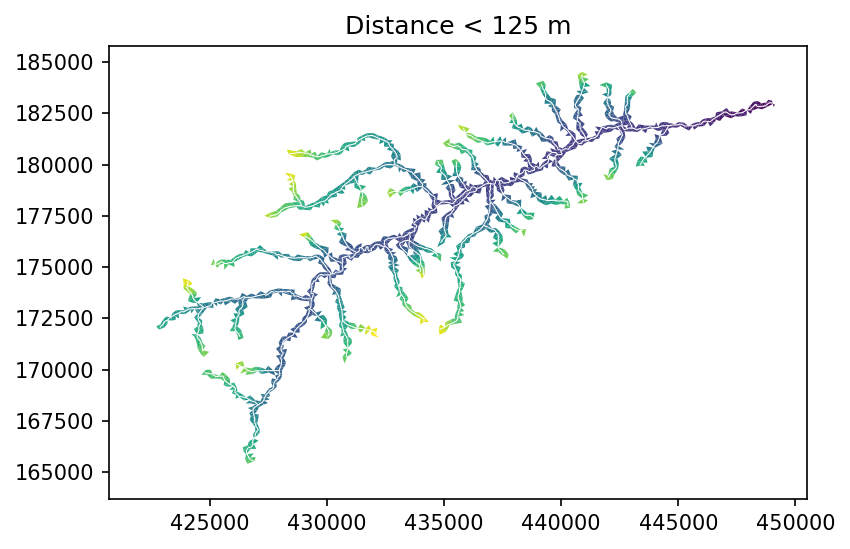

In [27]:
# river_idx, shps = pv.plot_riverbed(fname_river_shp, surface_vertex_xyz, triangles, 
#                                    # rivers=rivers[0],
#                                    dist_to_river=125)
river_idx_bool, shps = plot_riverbed(fname_river_shp, surface_vertex_xyz, triangles, 
                                   # rivers=rivers[0],
                                   dist_to_river=125)

### plot stream orders

Plot river orders

In [115]:
def find_streamOrder(fname_river_shp, triangles, vertex_xyz, river_idx):
    """Find stream orders given river network. """
    with fiona.open(fname_river_shp, 'r') as fid:
        profile = fid.profile
        shps = [s for (i,s) in fid.items()]  
    orders = [shp['properties']['StreamOrde'] for shp in shps]
    unique_orders=np.unique(orders)
    
    # get river shape for each order
    river_multilines = {}
    rivers = {}
    for i in unique_orders:
        rivers[i] = [shapely.geometry.shape(shp['geometry']) for shp in shps if shp['properties']['StreamOrde'] == i]
        river_multilines[i] = shapely.geometry.MultiLineString(rivers[i])
        
    # get river
    riverbed_orders = []
    for tri in triangles[river_idx]:
        verts = vertex_xyz[tri]
        bary = np.sum(np.array(verts), axis=0)/3
        bary_p = shapely.geometry.Point(bary[0], bary[1])
        distances = {}
        for i,iriver in river_multilines.items():
            distances[i] = bary_p.distance(iriver)
            
        # find min distance to specific streams to determine the stream order
        order = min(distances, key=distances.get)
        riverbed_orders.append(order)    
        
    return np.array(riverbed_orders), river_multilines, rivers

In [116]:
riverbed_orders, river_multilines, rivers = find_streamOrder(fname_river_shp, triangles, surface_vertex_xyz, new_river_idx)

Text(0.5, 1.0, 'Stream order')

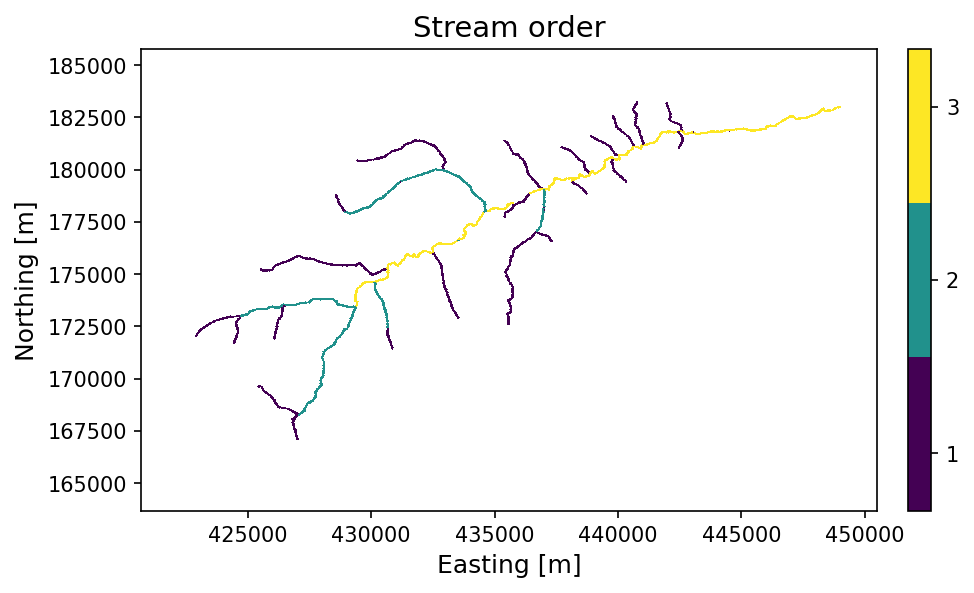

In [64]:
fig, ax = plt.subplots(1,1, figsize=(6.8,4))
tpc = ax.tripcolor(surface_vertex_xyz[:,0], surface_vertex_xyz[:,1], triangles[new_river_idx], 
                       facecolors= np.array(riverbed_orders), linewidth=0.01)
ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
# cb = plt.colorbar(tpc)
# cb.ax.set_ylabel("Stream order", labelpad=5)

workflow.colors.colorbar_index(3, cmap=plt.cm.viridis, labels=[1,2,3]) 
ax.set_title("Stream order")

In [27]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_streamOrder-transBG.png", dpi=300, transparent=True)
plt.close(fig)  

In [108]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_streamOrder.jpg", dpi=300)
plt.close(fig)  

### find sinuosity for main stem

The python code is borrowed from [sinuosity.py](https://github.com/sgrieve/sinuosity/blob/master/sinuosity.py) with minor midifications.

In [120]:
river_segs = rivers[3]

In [136]:
sinuosity = []
for iseg in river_segs:
    start_pt = list(iseg.coords)[0]
    end_pt = list(iseg.coords)[-1]
    straight_line = shapely.geometry.LineString((start_pt, end_pt))
    
    # calculate sinuosity = length_segment / the straightline distance from start to end point
    iseg_len = iseg.length
    isinuosity = iseg_len / straight_line.length
    
    sinuosity.append(isinuosity)

In [167]:
sinuosity

[1.011973566145754,
 1.2304583688348927,
 1.150255732030857,
 1.4276385206081184,
 1.2308900021652454,
 1.0,
 1.6383929706566522,
 1.3075078605024557,
 1.2267903917978087,
 1.301360493277789,
 1.0189690298991496,
 1.1043351592436916,
 1.0081613418076079,
 1.0103077951756294,
 1.1605659763928902,
 1.225344373098271,
 1.4747728561940618,
 1.2561948195126862,
 1.2500357988023452,
 1.0,
 1.2750422510861237,
 1.1234184861703347,
 1.2776067116672873,
 1.0,
 1.0430342279408678,
 1.4156396815396135,
 1.053600758167832]

In [146]:
# filter out straight lines
idx = np.array(sinuosity) > 1 

In [161]:
# plot segs along with river cells
river_3rd_idx = riverbed_orders == 3

In [190]:
tri_3rd = triangles[new_river_idx][river_3rd_idx]

In [198]:
# for i in river_segs[idx]:
# get river cells overlap with each segment
seg_orders = []
for tri in tri_3rd:
    verts = surface_vertex_xyz[tri]
    bary = np.sum(np.array(verts), axis=0)/3
    bary_p = shapely.geometry.Point(bary[0], bary[1])
    distances = {}
    for i,iriver in zip(range(len(river_segs)),river_segs):
        distances[i] = bary_p.distance(iriver)

    # find min distance to specific streams to determine the stream order
    iseg = min(distances, key=distances.get)
    seg_orders.append(iseg)    
    

In [199]:
seg_orders = np.array(seg_orders)

Text(0.5, 1.0, 'Main stem')

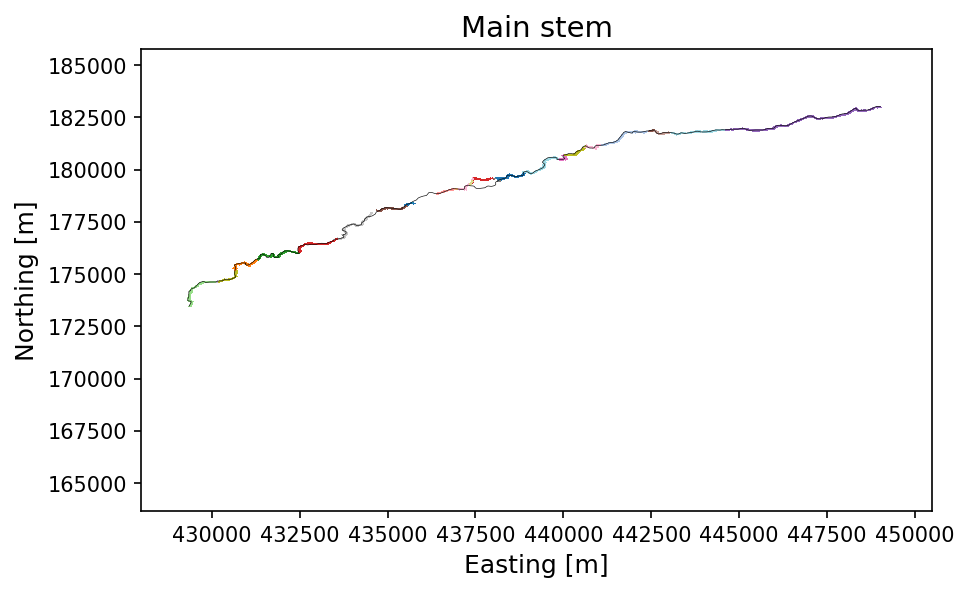

In [200]:
fig, ax = plt.subplots(1,1, figsize=(6.8,4))
tpc = ax.tripcolor(surface_vertex_xyz[:,0], surface_vertex_xyz[:,1], tri_3rd, 
                       facecolors= seg_orders, linewidth=0.01, cmap = 'tab20')

lines = [np.array(l.coords)[:,0:2] for l in river_segs]
lc = pltc.LineCollection(lines, linewidths = 0.3, color = 'k')
ax.add_collection(lc)

ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
# cb = plt.colorbar(tpc)
# cb.ax.set_ylabel("Stream order", labelpad=5)
ax.set_xlim([428000,None])
# workflow.colors.colorbar_index(3, cmap=plt.cm.viridis, labels=[1,2,3]) 
ax.set_title("Main stem")

In [215]:
# plot individual seg
iseg = 1
idx = seg_orders==iseg
itri = tri_3rd[idx]

Text(0.5, 1.0, 'Main stem (sinuosity =  1.23)')

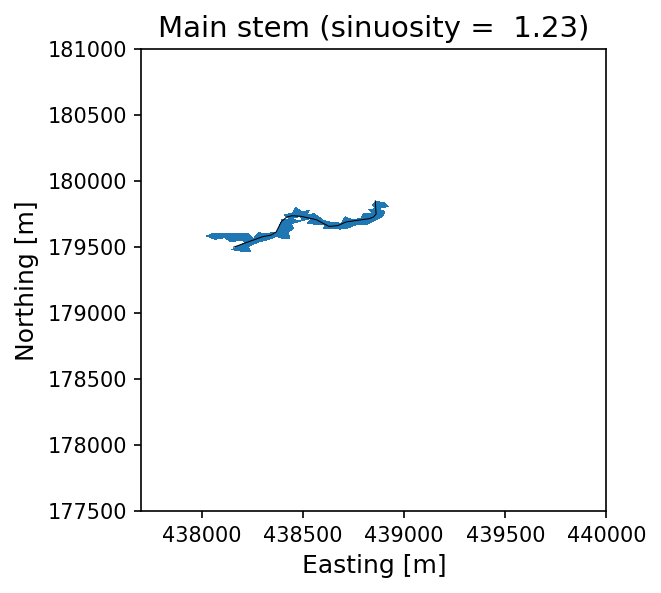

In [215]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
tpc = ax.tripcolor(surface_vertex_xyz[:,0], surface_vertex_xyz[:,1], itri, 
                       facecolors= seg_orders[idx], linewidth=0.01, cmap = 'tab20')

iriver = river_segs[iseg]
lines = [np.array(l.coords)[:,0:2] for l in [iriver]]
lc = pltc.LineCollection(lines, linewidths = 0.5, color = 'k')
ax.add_collection(lc)

ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
# cb = plt.colorbar(tpc)
# cb.ax.set_ylabel("Stream order", labelpad=5)
ax.set_xlim([437700,440000])
ax.set_ylim([177500,181000])
# workflow.colors.colorbar_index(3, cmap=plt.cm.viridis, labels=[1,2,3]) 
ax.set_title(f"Main stem (sinuosity = {sinuosity[iseg]: .2f})")

### riverbed aspect

> aspect : double or array_like
      Angle of $\hat{n}^\perp$ in map-view, measured
      clockwise from N = 0 [radians].

In [25]:
aspect = surface_vis.getArray('surface-aspect.cell.0')[0,:]

In [28]:
aspect.min(), aspect.max()

(-0.9340363846311189, 3.141551941717621)

2023-09-21 15:50:53,765 - root - INFO: No unit convertion.


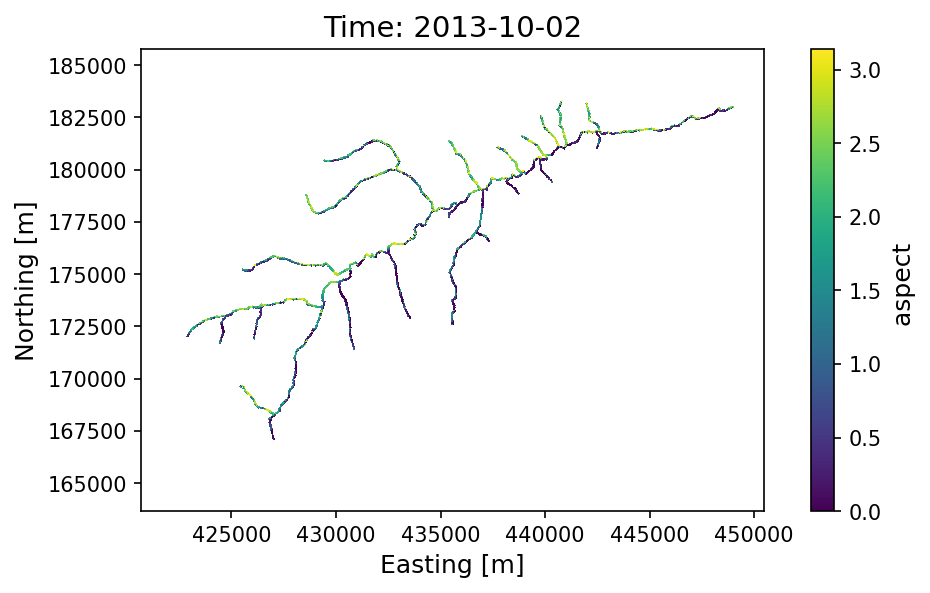

In [61]:
fig, ax, _ = pv.plot_surface_data(surface_vis,
                               var_name="aspect", colorbar = True,
                                  subset = True, subset_idx = new_river_idx,
                                # cmap = '',
#                                subset = True, subset_idx = river_idx,
                                  vmin = 0.00, vmax=3.14,
                               title = True, log = False, time_slice=1)

### riverbed slope

2023-09-20 17:17:05,617 - root - INFO: No unit convertion.


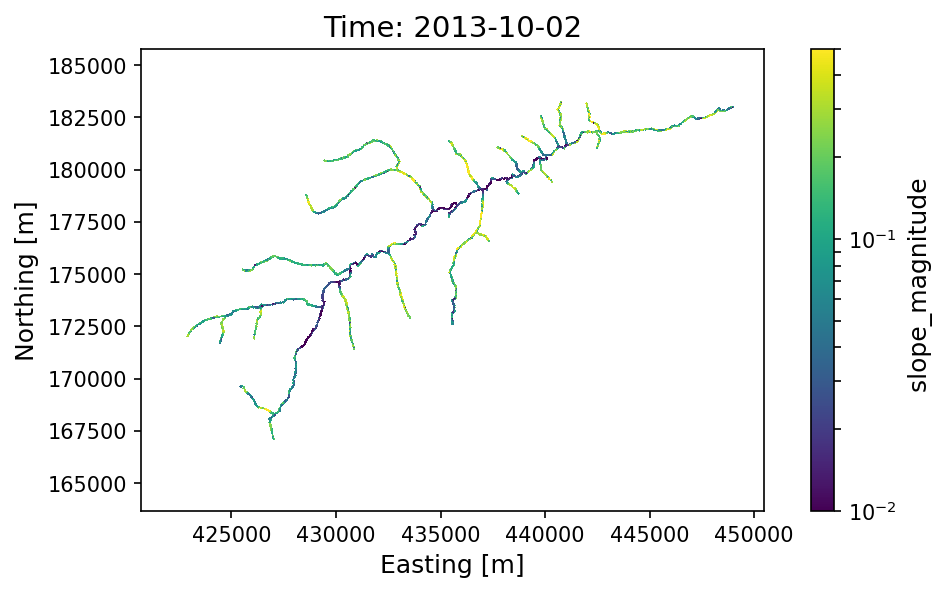

In [37]:
fig, ax, _ = pv.plot_surface_data(surface_vis,
                               var_name="slope_magnitude", colorbar = True,
                                  subset = True, subset_idx = new_river_idx,
                                # cmap = '',
#                                subset = True, subset_idx = river_idx,
                                  vmin = 0.01, vmax=0.5,
                               title = True, log = True, time_slice=1)

In [27]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_slope.tif", dpi=600)
plt.close(fig)  

### riverbed exchange flux

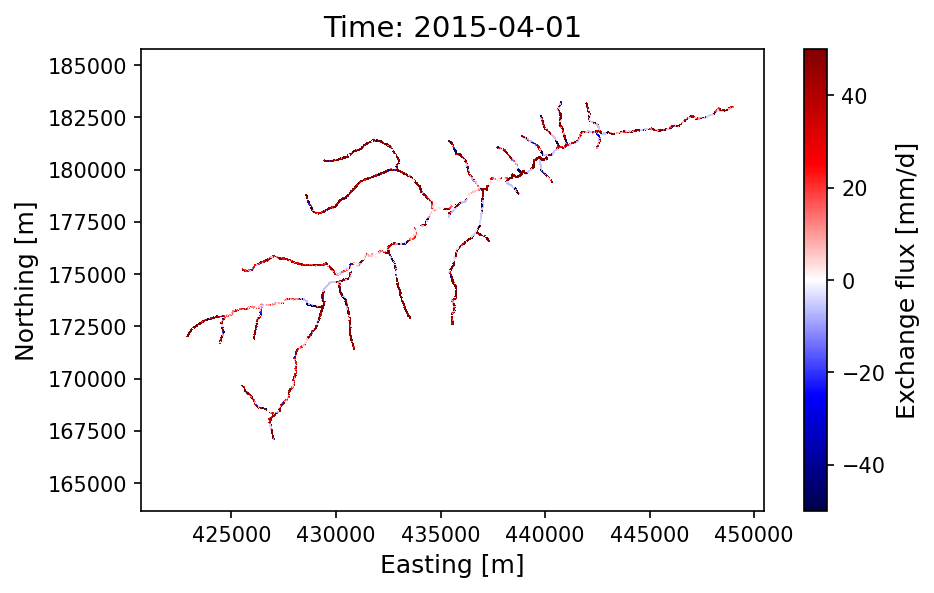

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6.8,4))
ax, tpc = pv.plot_surface_data(surface_vis,
                                   var_name="surface-surface_subsurface_flux", colorbar = True, 
                                   subset = True, subset_idx = new_river_idx, cmap = 'seismic', 
                                     clabel = "Exchange flux [mm/d]", 
                               robust = False, vmin=-50, vmax=50,
                               # facecolors=np.array(orders),
                                   title = True, log = False, time_slice= "2015-04-01", ax=ax)


In [60]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_exchange_flux_2015-4-1.jpg", dpi=300)
plt.close(fig)  

In [29]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_exchange_flux_2015-4-1.tif", dpi=600)
plt.close(fig)  

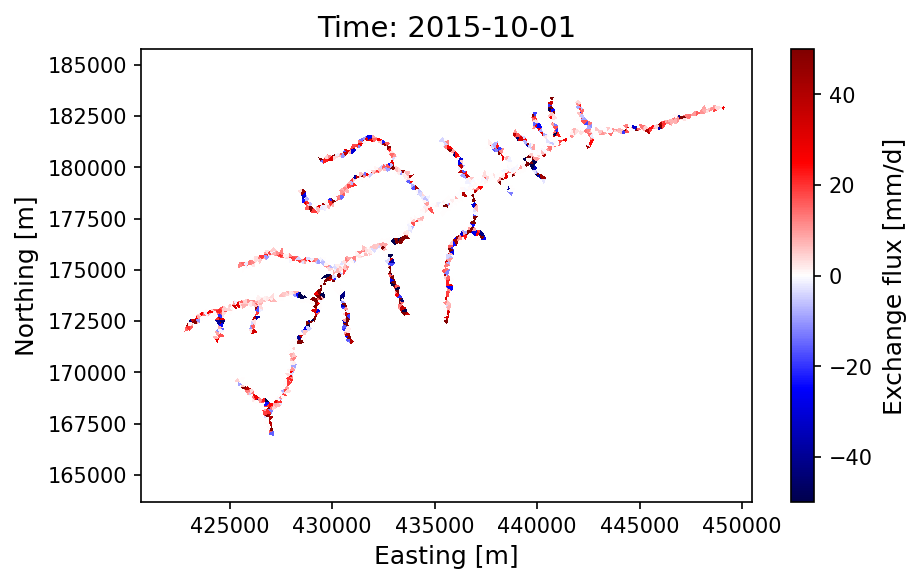

In [61]:
fig, ax = plt.subplots(1,1, figsize=(6.8,4))
ax, tpc = pv.plot_surface_data(surface_vis,
                                   var_name="surface-surface_subsurface_flux", colorbar = True, 
                                   subset = True, subset_idx = new_river_idx, cmap = 'seismic', 
                                     clabel = "Exchange flux [mm/d]", 
                               robust = False, vmin=-50, vmax=50,
                                   title = True, log = False, time_slice= "2015-10-01", ax=ax)

In [62]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_exchange_flux_2015-10-1.jpg", dpi=300)
plt.close(fig)  

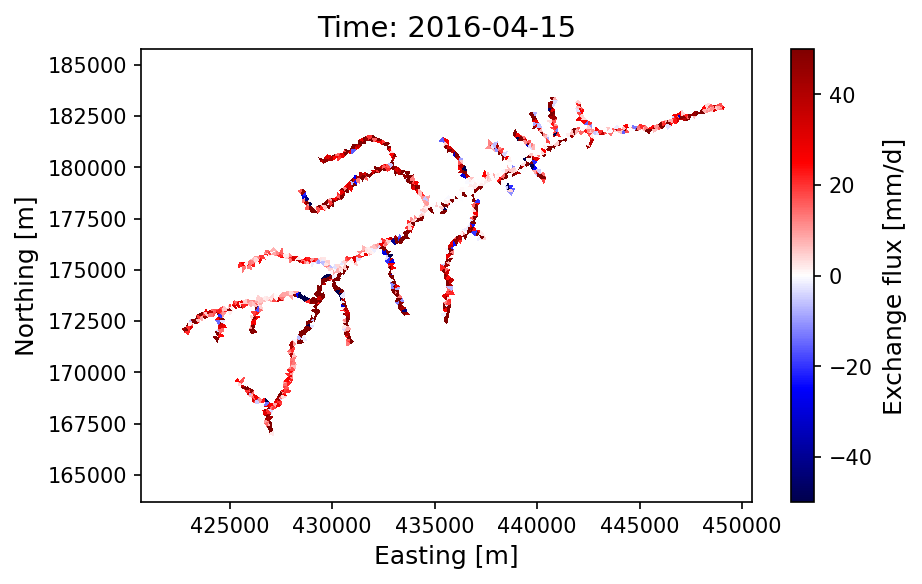

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6.8,4))
ax, tpc = pv.plot_surface_data(surface_vis,
                                   var_name="surface-surface_subsurface_flux", colorbar = True, 
                                   subset = True, subset_idx = new_river_idx, cmap = 'seismic', 
                                     clabel = "Exchange flux [mm/d]", 
                               robust = False, vmin=-50, vmax=50,
                                   title = True, log = False, time_slice= "2016-04-15", ax=ax)

### exchange flux vs surface slope

In [19]:
# river_idx = new_river_idx

riverbed_flux_df, _, sub_area = var_across_riverbed(surface_vis, "surface_subsurface_flux", new_river_idx, 
                                  weighted_mean=True, total_volume=True)

In [20]:
# river_idx = new_river_idx

slope_df, _, sub_area = var_across_riverbed(surface_vis, "slope_magnitude", new_river_idx, 
                                  weighted_mean=False, total_volume=False)

In [21]:
slope_df

,0,1,2,3,4,5,6,7,8,9,...,6322,6323,6324,6325,6326,6327,6328,6329,6330,6331
datetime,,,,,,,,,,,,,,,,,,,,,
2013-10-01,0.067811,0.214887,0.1238,0.115199,0.076517,0.108106,0.07114,0.086279,0.063839,0.054658,...,0.043434,0.058407,0.029361,0.074311,0.036924,0.040049,0.008071,0.043033,0.067662,0.058934
2013-10-02,0.067811,0.214887,0.1238,0.115199,0.076517,0.108106,0.07114,0.086279,0.063839,0.054658,...,0.043434,0.058407,0.029361,0.074311,0.036924,0.040049,0.008071,0.043033,0.067662,0.058934
2013-10-03,0.067811,0.214887,0.1238,0.115199,0.076517,0.108106,0.07114,0.086279,0.063839,0.054658,...,0.043434,0.058407,0.029361,0.074311,0.036924,0.040049,0.008071,0.043033,0.067662,0.058934
2013-10-04,0.067811,0.214887,0.1238,0.115199,0.076517,0.108106,0.07114,0.086279,0.063839,0.054658,...,0.043434,0.058407,0.029361,0.074311,0.036924,0.040049,0.008071,0.043033,0.067662,0.058934
2013-10-05,0.067811,0.214887,0.1238,0.115199,0.076517,0.108106,0.07114,0.086279,0.063839,0.054658,...,0.043434,0.058407,0.029361,0.074311,0.036924,0.040049,0.008071,0.043033,0.067662,0.058934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-27,0.067811,0.214887,0.1238,0.115199,0.076517,0.108106,0.07114,0.086279,0.063839,0.054658,...,0.043434,0.058407,0.029361,0.074311,0.036924,0.040049,0.008071,0.043033,0.067662,0.058934
2016-09-28,0.067811,0.214887,0.1238,0.115199,0.076517,0.108106,0.07114,0.086279,0.063839,0.054658,...,0.043434,0.058407,0.029361,0.074311,0.036924,0.040049,0.008071,0.043033,0.067662,0.058934
2016-09-29,0.067811,0.214887,0.1238,0.115199,0.076517,0.108106,0.07114,0.086279,0.063839,0.054658,...,0.043434,0.058407,0.029361,0.074311,0.036924,0.040049,0.008071,0.043033,0.067662,0.058934


In [47]:
riverbed_flux_df = riverbed_flux_df.iloc[1:, :].copy()

In [56]:
riverbed_flux_df

,0,1,2,3,4,5,6,7,8,9,...,6324,6325,6326,6327,6328,6329,6330,6331,average [mm/d],sum [m^3/d]
datetime,,,,,,,,,,,,,,,,,,,,,
2013-10-02,51.770115,19.579592,95.975679,41.844632,-10.204749,21.728880,52.620882,78.873691,34.248186,1.637483,...,13.437892,36.477904,10.129127,7.463927,11.842176,57.092858,7.975630,22.903623,32.388637,156396.931650
2013-10-03,51.754443,16.771226,95.782320,41.746874,-10.442424,21.651439,52.563676,78.917541,34.030376,0.890230,...,13.157366,34.234028,10.049613,7.284182,11.705384,57.325240,7.663322,22.692849,34.287635,165566.734273
2013-10-04,51.519743,11.761887,95.341221,41.477962,-10.815700,21.343922,52.294219,78.696166,33.664444,-0.902914,...,13.026062,32.510713,10.073166,6.991288,11.531942,58.340751,6.947740,22.358292,33.337362,160978.096088
2013-10-05,51.376583,5.772088,94.966439,41.312225,-11.011390,21.100026,52.136412,78.569434,33.469833,-3.133969,...,13.046002,31.526527,10.174820,6.804944,11.471740,59.234295,6.443498,22.169251,32.292646,155933.415600
2013-10-06,51.488248,0.000000,94.394199,41.413117,-10.919516,21.129198,52.258110,78.709903,33.562239,-5.293705,...,13.125909,30.749646,10.326841,6.771302,11.528004,59.785073,6.283226,22.166475,31.594906,152564.192971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-27,50.570237,1.973874,58.732771,40.543881,-11.100829,9.464047,52.188280,78.875993,33.248174,-21.329654,...,14.997304,28.201208,13.345878,7.105064,12.183666,65.270562,4.417805,22.063693,21.764553,105095.787108
2016-09-28,50.083031,0.000000,57.882306,40.061196,-11.545320,7.180765,51.748378,78.419808,32.792082,-22.203159,...,14.738210,27.524740,13.193287,6.782002,11.919309,65.159191,4.020371,21.748151,21.087729,101827.565107
2016-09-29,50.237798,0.718630,57.213030,40.159896,-11.334219,4.273898,51.944808,78.633706,32.997078,-22.397368,...,14.876446,27.365722,13.378477,6.876029,12.053364,65.395898,4.109841,21.884774,21.180437,102275.229950


In [55]:
riverbed_flux_df.iloc[:, :-2].max().max()

2965.145371999238

In [23]:
slope = slope_df.iloc[0,:]

In [49]:
flux1 = riverbed_flux_df.loc["2015-04-01", 0:6331]
flux2 = riverbed_flux_df.loc["2015-10-01", 0:6331]

In [88]:
depth = surface_vis.getArray("surface-ponded_depth")
time_idx = t == datetime.datetime(2015,4,1)
river_depth = depth[time_idx, new_river_idx]
ponded_idx = river_depth > 0.0

In [94]:
def get_spearman_corr(islope, iflux, idx=None):  
    if idx is not None:
        iflux = iflux[idx]
        islope = islope[idx]

    # get coorelation between Std vs slope
    correlation, p_value = scipy.stats.spearmanr(islope, np.abs(iflux))
    print(f"Spearman Rank Correlation: {correlation}")
    print(f"P-Value: {p_value}")

In [222]:
flux_med = riverbed_flux_df.iloc[:, 0:6332].median()
flux_std = riverbed_flux_df.iloc[:, 0:6332].std()

In [223]:
get_spearman_corr(slope, flux_med), get_spearman_corr(slope, flux_std)

Spearman Rank Correlation: -0.07924349034991113
P-Value: 2.7121671895383504e-10
Spearman Rank Correlation: 0.19500306056138564
P-Value: 2.637166578711315e-55


(None, None)

In [224]:
get_spearman_corr(slope, flux_med, idx=ponded_idx), get_spearman_corr(slope, flux_std, idx=ponded_idx)

Spearman Rank Correlation: 0.18850503736745944
P-Value: 1.9291911597198386e-44
Spearman Rank Correlation: 0.22247292889003448
P-Value: 1.2543471054574103e-61


(None, None)

In [103]:
def get_spearman_corr_by_riverOrder(islope, iflux, river_order, idx=None):  
    # get correlation among stream orders
    if idx is not None:
        ind = np.logical_and(riverbed_orders == river_order, idx)
    else:
        ind = riverbed_orders == river_order
    iflux = iflux[ind]
    islope = islope[ind]

    # get coorelation between Std vs slope
    correlation, p_value = scipy.stats.spearmanr(islope, np.abs(iflux))
    print(f"Spearman Rank Correlation for river order {river_order}: {correlation}")
    print(f"P-Value for river order {river_order}: {p_value}")

In [105]:
get_spearman_corr_by_riverOrder(slope, flux_std, 1), get_spearman_corr_by_riverOrder(slope, flux_std, 2),get_spearman_corr_by_riverOrder(slope, flux_std, 3),

Spearman Rank Correlation for river order 1: 0.2082915974789748
P-Value for river order 1: 9.481636236556176e-32
Spearman Rank Correlation for river order 2: 0.2863287367018562
P-Value for river order 2: 6.945067733369583e-30
Spearman Rank Correlation for river order 3: 0.24257929357564134
P-Value for river order 3: 1.8646937055876306e-24


(None, None, None)

In [107]:
get_spearman_corr_by_riverOrder(slope, flux_std, 1, idx=ponded_idx), 
get_spearman_corr_by_riverOrder(slope, flux_std, 2, idx=ponded_idx),
get_spearman_corr_by_riverOrder(slope, flux_std, 3, idx=ponded_idx),

Spearman Rank Correlation for river order 1: 0.23936502283783875
P-Value for river order 1: 3.168346741534188e-35
Spearman Rank Correlation for river order 2: 0.3143212254021657
P-Value for river order 2: 6.934598154461184e-33
Spearman Rank Correlation for river order 3: 0.3024074177190305
P-Value for river order 3: 1.1480804669856542e-31


(None,)

In [106]:
get_spearman_corr_by_riverOrder(slope, flux_med, 1), get_spearman_corr_by_riverOrder(slope, flux_med, 2),get_spearman_corr_by_riverOrder(slope, flux_med, 3),

Spearman Rank Correlation for river order 1: -0.10820689972557848
P-Value for river order 1: 1.5224702695955527e-09
Spearman Rank Correlation for river order 2: -0.003367301386055806
P-Value for river order 2: 0.8959801759101407
Spearman Rank Correlation for river order 3: -0.20083140633827654
P-Value for river order 3: 4.141748639469023e-17


(None, None, None)

In [108]:
get_spearman_corr_by_riverOrder(slope, flux_med, 1, idx=ponded_idx), 
get_spearman_corr_by_riverOrder(slope, flux_med, 2, idx=ponded_idx),
get_spearman_corr_by_riverOrder(slope, flux_med, 3, idx=ponded_idx),

Spearman Rank Correlation for river order 1: 0.1463724082539632
P-Value for river order 1: 6.223819534535088e-14
Spearman Rank Correlation for river order 2: 0.22768778883352192
P-Value for river order 2: 1.2897288867968299e-17
Spearman Rank Correlation for river order 3: 0.0978335451572734
P-Value for river order 3: 0.00020901823988366813


(None,)

Text(0, 0.5, 'exchange flux')

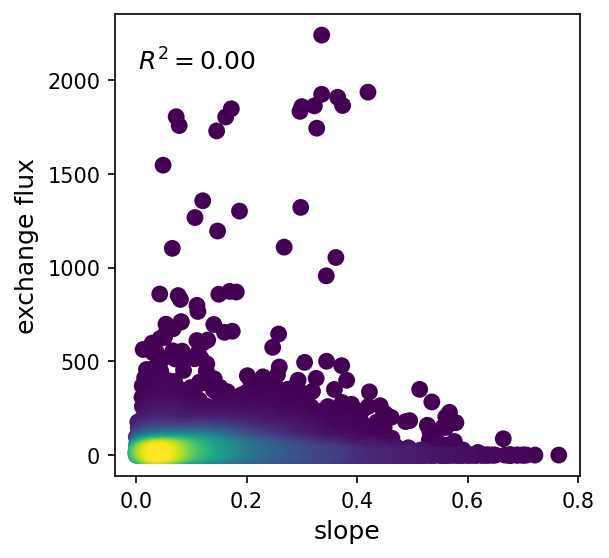

In [57]:
gp.one2one_plot(slope, np.abs(flux_med), equal_aspect=False, show_line=False, show_density=True)
plt.xlabel('slope')
plt.ylabel('exchange flux')

Text(0, 0.5, 'exchange flux')

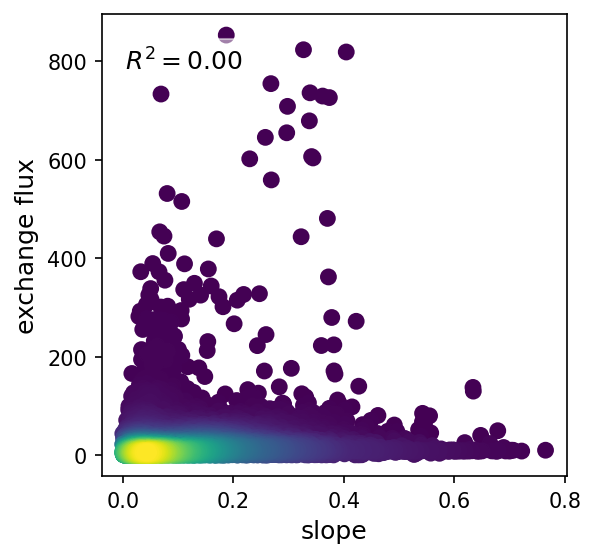

In [58]:
gp.one2one_plot(slope, np.abs(flux_std), equal_aspect=False, show_line=False, show_density=True)
plt.xlabel('slope')
plt.ylabel('exchange flux')

In [31]:
import scipy
# Calculate Spearman rank correlation
correlation, p_value = scipy.stats.spearmanr(slope, np.abs(flux1))

# Print the correlation coefficient and p-value
print(f"Spearman Rank Correlation: {correlation}")
print(f"P-Value: {p_value}")

# Calculate Kendall's Tau correlation
correlation, p_value = scipy.stats.kendalltau(slope, np.abs(flux1))

# Print the correlation coefficient and p-value
print(f"Kendall's Tau Correlation: {correlation}")
print(f"P-Value: {p_value}")

Spearman Rank Correlation: 0.025127064235607795
P-Value: 0.0455674143489576
Kendall's Tau Correlation: 0.02079142044849165
P-Value: 0.013103389814976208


Text(0, 0.5, 'exchange flux')

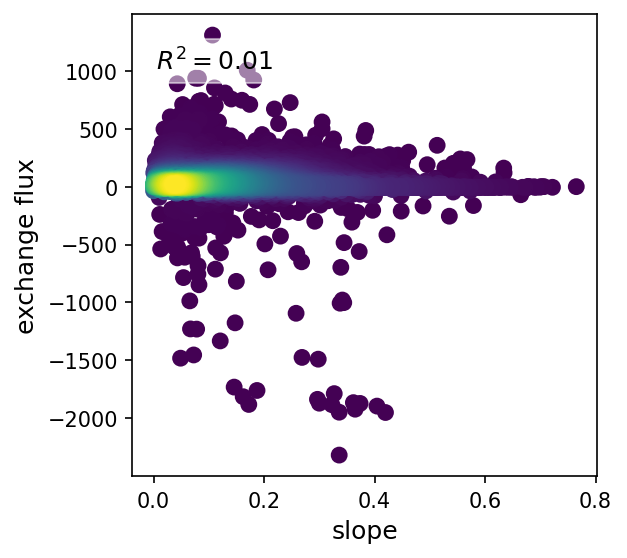

In [27]:
gp.one2one_plot(slope, flux1, equal_aspect=False, show_line=False, show_density=True)
plt.xlabel('slope')
plt.ylabel('exchange flux')

Text(0, 0.5, 'exchange flux')

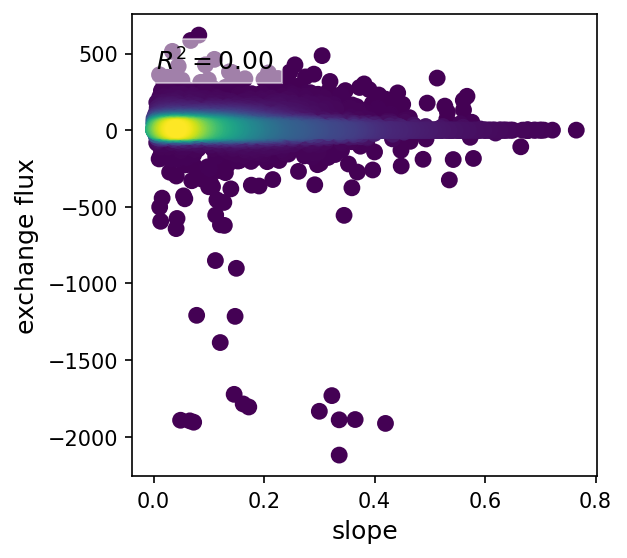

In [28]:
gp.one2one_plot(slope, flux2, equal_aspect=False, show_line=False, show_density=True)
plt.xlabel('slope')
plt.ylabel('exchange flux')

### exchange flux vs sinuosity

In [234]:
iseg = 1
isinuosity = sinuosity[iseg]
idx = seg_orders==iseg
print(f"river ids: {np.arange(6332)[river_3rd_idx][idx]}")

river ids: [4478 4492 4493 4494 4495 4496 4497 4498 4499 4500 4584 4585 4586 4587
 4588 4589 4590 4591 4592 4593 4594 4595 4596 4597 4598 4599 4600 4601
 4602 4603 4604 4605 4606 4607 4608 4609 4610 4611 4612 4613 4614 4615
 4616 4617 4618 4619 4620 4621 4622 4623 4624 4625 4629 4632 4637 4639
 4641 4642 4651 4652 4653 4654 4655 4656 4657 4658 4659 4660 4661 4662
 4663 4664 4665 4666 4667 4668 4669 4670 4671]


In [231]:
iflux_med = riverbed_flux_df.iloc[:, 0:6332].loc[:, river_3rd_idx].loc[:, idx].median()
iflux_std = riverbed_flux_df.iloc[:, 0:6332].loc[:, river_3rd_idx].loc[:, idx].std()

In [248]:
river_seg_flux_med = []
river_seg_flux_std = []
for iseg in range(len(river_segs)):
    idx = seg_orders==iseg
    iflux_med = riverbed_flux_df.iloc[:, 0:6332].loc[:, river_3rd_idx].loc[:, idx].median().median()
    iflux_std = riverbed_flux_df.iloc[:, 0:6332].loc[:, river_3rd_idx].loc[:, idx].std().median()
    
    river_seg_flux_med.append(iflux_med)
    river_seg_flux_std.append(iflux_std)

In [276]:
df = pd.DataFrame({'sinuosity':np.array(sinuosity), 'flux_med':np.abs(river_seg_flux_med), 'flux_std':np.abs(river_seg_flux_std)})
df = df.dropna()[(df.sinuosity > 1.0) & (df.flux_med > 0)]

/tmp/ipykernel_658653/213932767.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.dropna()[(df.sinuosity > 1.0) & (df.flux_med > 0)]


In [278]:
get_spearman_corr(df.sinuosity, df.flux_med), get_spearman_corr(df.sinuosity, df.flux_std)

Spearman Rank Correlation: 0.22077922077922077
P-Value: 0.33618808709526804
Spearman Rank Correlation: 0.2935064935064935
P-Value: 0.19659251726168686


(None, None)

Text(0, 0.5, 'exchange flux_median')

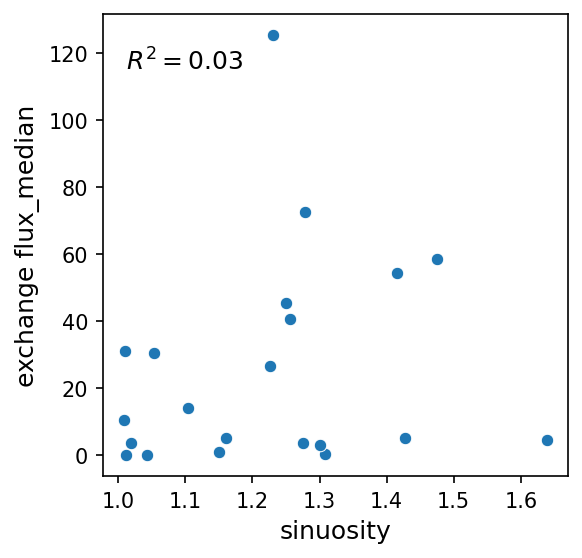

In [279]:
gp.one2one_plot(df.sinuosity, df.flux_med, equal_aspect=False, show_line=False, show_density=False)
plt.xlabel('sinuosity')
plt.ylabel('exchange flux_median')

Text(0, 0.5, 'exchange flux_std')

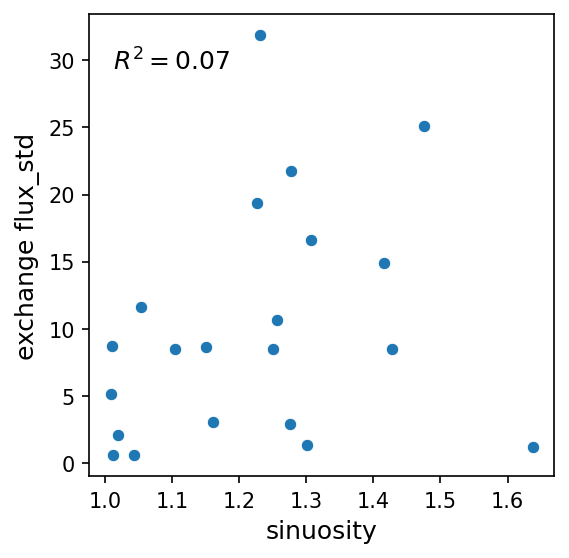

In [280]:
gp.one2one_plot(df.sinuosity, df.flux_std, equal_aspect=False, show_line=False, show_density=False)
plt.xlabel('sinuosity')
plt.ylabel('exchange flux_std')

### flux diff

In [35]:
var_name = "surface-surface_subsurface_flux"
vis_data = surface_vis
dat = vis_data.getArray(var_name)
origin_date = "1980-01-01"
time_slice1= "2015-10-01"
time_slice2= "2015-04-01"
_, time_idx1 = pv.get_time(vis_data, time_slice1, origin_date=origin_date)
_, time_idx2 = pv.get_time(vis_data, time_slice2, origin_date=origin_date)
idat1 = dat[time_idx1, :]
idat2 = dat[time_idx2, :]
diff = idat1 - idat2

# tpc = ax.tripcolor(vertex_xyz[:,0], vertex_xyz[:,1], iconn, 
#                        facecolors= colors, linewidth=0.01,
#                    norm=matplotlib.colors.SymLogNorm(linthresh=linthresh,                                                                                             linscale=linscale, vmin=vmin, vmax=vmax), 
#                    **kwargs)

In [36]:
idat1

array([0.00348982, 0.00952358, 0.00353972, ..., 0.00079236, 0.00145045,
       0.00147175])

Text(0.5, 1.0, 'Flux difference (2015-10-01 - 2015-04-01)')

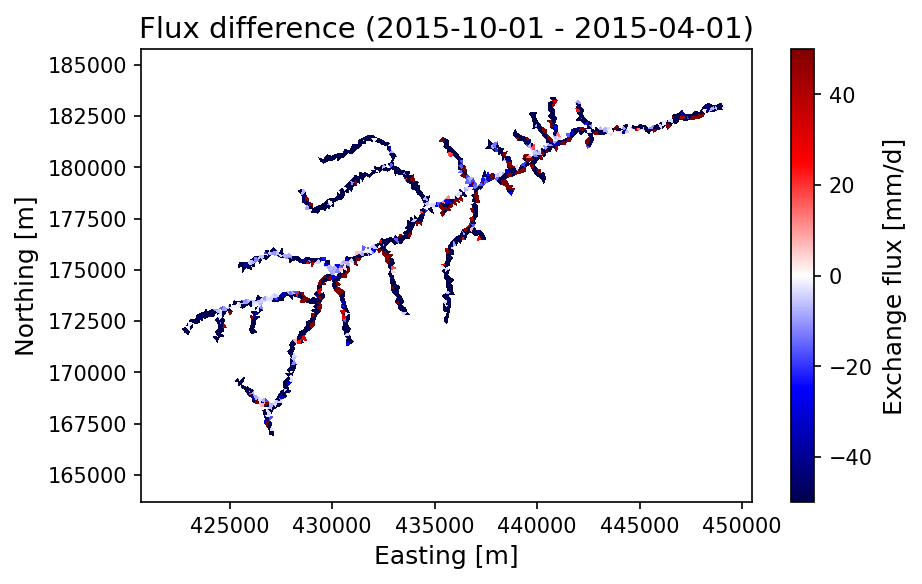

In [64]:
fig, ax = plt.subplots(1,1, figsize=(6.8,4))
ax, tpc = pv.plot_surface_data(surface_vis,
                               facecolors=diff,
                                   var_name="surface-surface_subsurface_flux", colorbar = True, 
                                   subset = True, subset_idx = new_river_idx, cmap = 'seismic', 
                                     clabel = "Exchange flux [mm/d]", 
                               # robust = True, 
                               vmin=-50, vmax=50,
                                   title = False, log = False, 
                               time_slice= "2015-10-01", ax=ax)
ax.set_title(f"Flux difference ({time_slice1} - {time_slice2})")
# ax.set_title(f"Flux difference")

In [65]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_flux_diff_2015.jpg", dpi=300)
plt.close(fig)  

### batch plot

In [ ]:
# for i in range(times.shape[0])[::5]:
#     itime = t[i]
#     fig, ax = plt.subplots(1,1, figsize=(6.8,4))
#     pv.plot_surface_data(surface_vis, surface_vertex_xyz, surface_conn, 
#                                    var_name="surface-surface_subsurface_flux", colorbar = True, 
#                                    subset = True, subset_idx = river_idx, cmap = 'seismic', 
#                                      clabel = "Exchange flux [mm/d]",
#                                    title = True, log = True, time_slice= i, ax=ax)
#     fig.savefig(fig_dir + f"ARW-250m-gauss3/riverbed_flux/flux-{itime.date()}.jpg", dpi=300)
#     plt.tight_layout()
#     plt.close(fig)

get variable: surface-surface_subsurface_flux.cell.0


(<matplotlib.axes._subplots.AxesSubplot at 0x2aab930a1748>,
 <matplotlib.collections.PolyCollection at 0x2aab92928c18>)

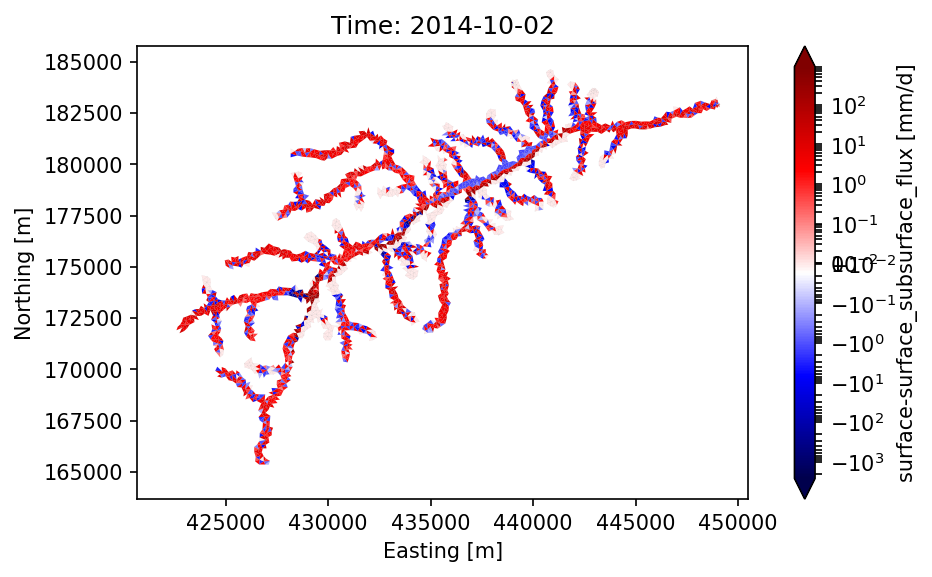

### quantile plots

Load exchange flux for the riverbed cells.

In [25]:
# river_idx = new_river_idx

sub_data_df, sub_data, sub_area = var_across_riverbed(surface_vis, "surface_subsurface_flux", new_river_idx, 
                                  weighted_mean=True, total_volume=True)

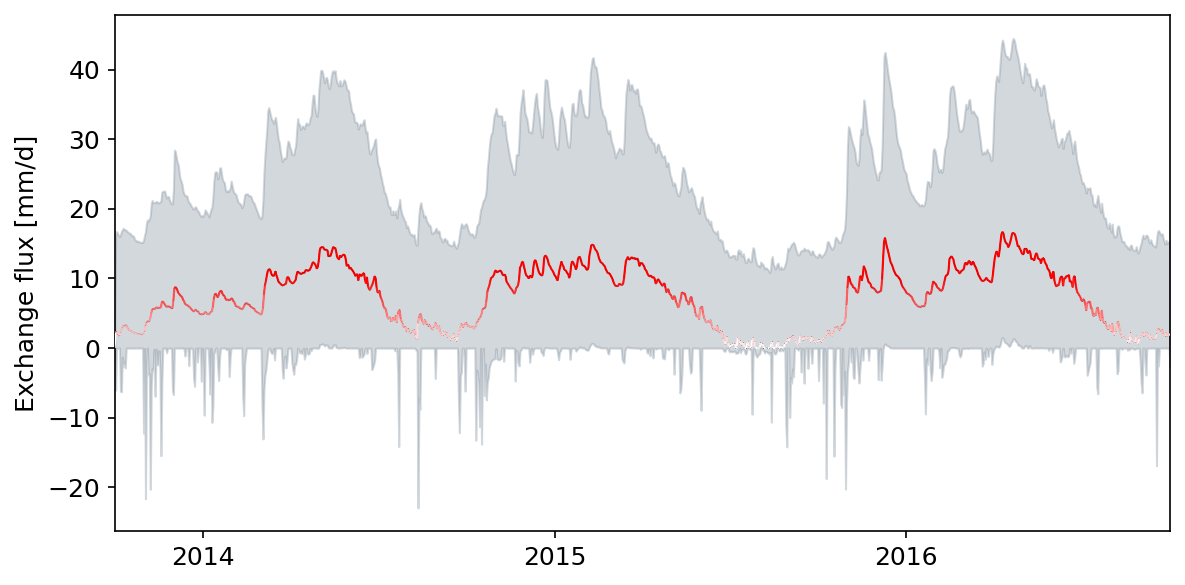

In [28]:
idf = sub_data_df.iloc[:, :-2]
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax, quantiles_df = gp.quantile_plot(idf, ax = ax, weights= sub_area)
line = gp.colorline(t, quantiles_df['50'], norm_lim=[-10, 10], lw = 1, ax=ax, zorder = 99)
ax.set_ylabel("Exchange flux [mm/d]", fontsize = 12)
# ax.set_ylim([-25, 10])
ax.set_xlim([t[0], t[-1]])
ax.tick_params(axis='both', which='major', labelsize=12)
# titles = f"Time: {itime.date()}"
# plt.title(titles, fontsize = 14)
plt.tight_layout()

### animation with met

In [33]:
met_df = pd.read_csv(fname_water_balance, index_col=0, parse_dates=True)

In [ ]:
custom_lines = ut.custom_legend(['steelblue', 'darkorange', 'crimson','darkgreen'], ['rain', 'snowmelt', 'ET', 'discharge'])

In [ ]:
fontsize = 12
for i in tqdm(range(times.shape[0])[-1::5]):
    itime = t[i]
    titles = f"Time: {itime.date()}"
    
    idf = sub_data_df.loc[:itime, :]
    imet = met_df.loc[:itime, :]
    fig, axes = plt.subplots(2,1, figsize=(8, 6), sharex = True)
    ax = axes[0]
    ax1 = ax.twinx()
    ax.plot(imet.index, imet["rain precipitation [mm d^-1]"],lw = 0.5, color = 'steelblue', label = 'rain')
    ax.plot(imet.index, imet["snowmelt [mm d^-1]"], lw = 0.5, color = 'darkorange', label = 'snowmet')
#     met_df.loc[:itime, :].plot(y =["rain precipitation [mm d^-1]", "snowmelt [mm d^-1]", 'total evapotranspiration [mm d^-1]'], ax = ax)
    ax1.plot(imet.index, imet['total evapotranspiration [mm d^-1]'], lw = 0.5, color = 'darkgreen', label = 'ET')
    ax1.plot(imet.index, imet['watershed boundary discharge [m/d]']*1000, color = 'crimson', lw = 0.5, label = 'discharge')
    ax.set_xlim([t[0], t[-1]])
    ax.set_ylim([0, max(np.max(met_df["rain precipitation [mm d^-1]"]), np.max(met_df["snowmelt [mm d^-1]"]))])
    ax1.set_ylim([0, np.max(met_df['watershed boundary discharge [m/d]']*1000)])
    ax.set_ylabel('Rain/snowmelt [mm/d]', fontsize = fontsize)
    ax1.set_ylabel('ET/discharge [mm/d]', fontsize = fontsize)
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.title(titles, fontsize = 16, pad= 25)
    # plt.legend(custom_lines, ['rain', 'snowmelt', 'ET', 'discharge'], loc = 'upper left', 
    #            bbox_to_anchor =(0.15, 1.12), ncol = 4, frameon = False)
    ut.custom_legend(['steelblue', 'darkorange', 'crimson','darkgreen'], 
                     ['rain', 'snowmelt', 'ET', 'discharge'], loc = 'upper left', 
               bbox_to_anchor =(0.15, 1.12), ncol = 4,  ax=ax)
    
    ax =axes[1]
    quantiles_df = gp.quantile_plot(idf, ax = ax, fill_color = 'slategray', weights= sub_area)
    line = gp.colorline(t[:i+1], quantiles_df['50'], norm_lim=[-3, 3], lw = 1, ax=ax, zorder = 99)
    ax.set_ylabel("Exchange flux [mm/d]", fontsize = 12)
    ax.set_ylim([-25, 10])
    ax.set_xlim([t[0], t[-1]])
    ax.tick_params(axis='both', which='major', labelsize=12)
    
#     plt.title(titles, fontsize = 14)
    plt.tight_layout()
    
#     fig.savefig(fig_dir + f"ARW-250m-gauss3/riverbed_flux_quantile/flux-{itime.date()}.jpg", dpi=300)
#     plt.close(fig)    

### subset cells below water

This will subset riverbed cells with ponded water on surface. For dry cells, the exchange flux is mostly controlled by ET?

In [35]:
depth = surface_vis.getArray("surface-ponded_depth")
river_depth = depth[:, river_idx]

In [36]:
mean_ponded_riverbed_flux =[]
sum_ponded_riverbed_flux =[]
for i in range(sub_data.shape[0]):
    idx = river_depth[i, :] > 0
    iflux_mean = np.average(sub_data[i, idx], weights=sub_area[idx])
    mean_ponded_riverbed_flux.append(iflux_mean)
    iflux_sum = np.dot(sub_data[i, idx]/1000, sub_area[idx])
    sum_ponded_riverbed_flux.append(iflux_sum)

In [47]:
df = pd.read_csv(fname_water_balance, index_col=0, parse_dates=True)

In [48]:
colors = mcolors.colors('matplotlib')

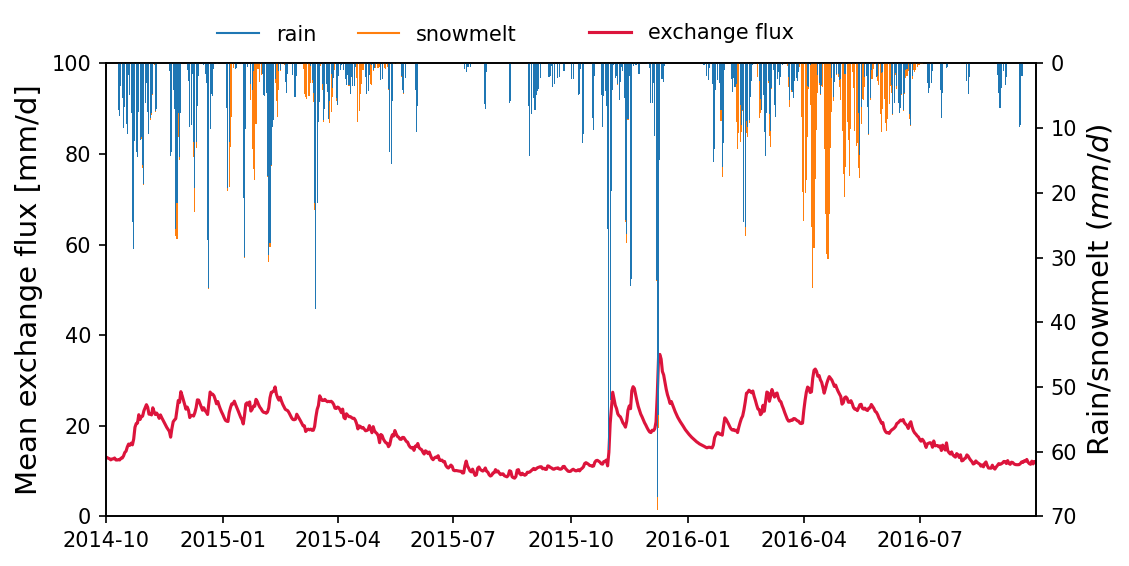

In [50]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(t, mean_ponded_riverbed_flux, 'crimson', label = 'exchange flux')
ax.set_ylim([0,100])

ax1 = ax.twinx()
ax1.bar(df.index, df["rain precipitation [mm d^-1]"], lw=1.5)
ax1.bar(df.index, df["snowmelt [mm d^-1]"], lw=1.5, bottom = df["rain precipitation [mm d^-1]"])

ax1.set_ylim([0,70])
ax1.invert_yaxis()
ax1.set_ylabel('Rain/snowmelt ($mm/d$)', fontsize = 14)
ut.custom_legend(colors[:2], ['rain', 'snowmelt'], loc = 'lower left',  ax = ax1, 
                    bbox_to_anchor =(0.1 , 1.0), ncol = 2)
ax1.tick_params(axis=u'x', which=u'minor',length=0)

ax.set_xlim([datetime.datetime(2014,10,1), datetime.datetime(2016,9,30)])
ax.set_ylabel("Mean exchange flux [mm/d]", fontsize=14)
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor =(0.5 , 1.13), ncol = 1)

In [51]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_exchange_flux_mean.jpg", dpi=300)
plt.close(fig)  

In [49]:
sub_data_df['average below water [mm/d]'] = mean_ponded_riverbed_flux
sub_data_df['sum below water [m^3/d]'] = sum_ponded_riverbed_flux

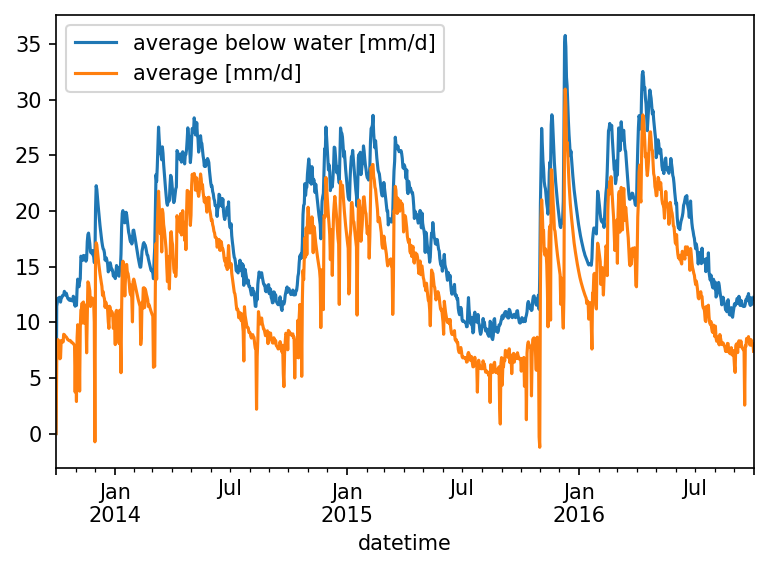

In [50]:
sub_data_df['average below water [mm/d]'].plot()
sub_data_df['average [mm/d]'].plot()
plt.legend()

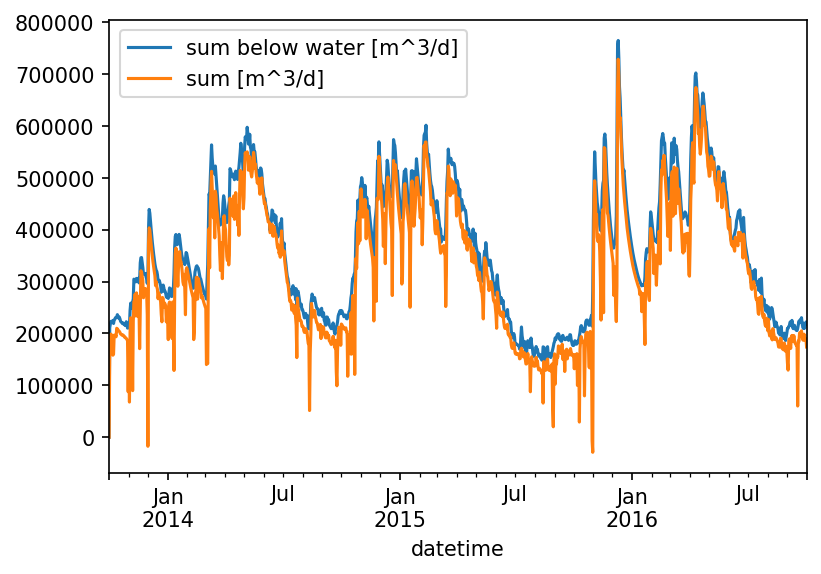

In [51]:
sub_data_df['sum below water [m^3/d]'].plot()
sub_data_df['sum [m^3/d]'].plot()
plt.legend()

In [53]:
sub_data_df.to_csv(fname_exchange_flux)

### Exchange flux based on stream order

In [152]:
depth = surface_vis.getArray("surface-ponded_depth")
river_depth = depth[:, river_idx]

In [153]:
ave_flux = {}
for i in (np.arange(3)+1):
    idx = riverbed_orders == i
    iflux = np.average(sub_data[:, idx], weights=sub_area[idx], axis=1)
    ave_flux[i] = iflux

<AxesSubplot:>

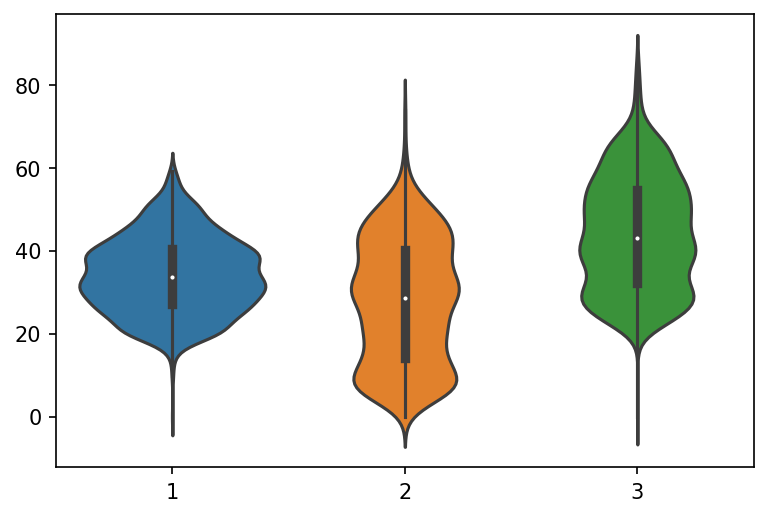

In [120]:
df = pd.DataFrame(ave_flux)

sns.violinplot(data = df)

Below ponded water

In [154]:
ave_flux = {}
for i in (np.arange(3)+1):
    flux = []
    for j in range(sub_data.shape[0]):
        # select cells below water
        idx1 = river_depth[j, :] > 0
        idx2 = riverbed_orders == i
        idx = np.logical_and(idx1, idx2)
        iflux = np.average(sub_data[j, idx], weights=sub_area[idx])
        flux.append(iflux)
    ave_flux[i] = flux

Text(0, 0.5, 'Mean exchange flux [mm/d]')

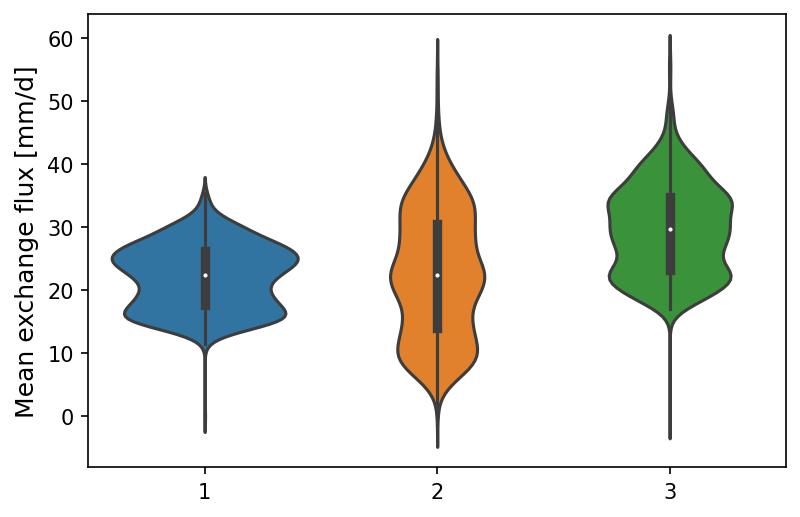

In [155]:
df = pd.DataFrame(ave_flux)

fig,ax=plt.subplots(1,1, figsize=(6,4))
sns.violinplot(data = df, ax=ax)
ax.set_ylabel("Mean exchange flux [mm/d]", fontsize=12)

Text(0, 0.5, 'Mean exchange flux [mm/d]')

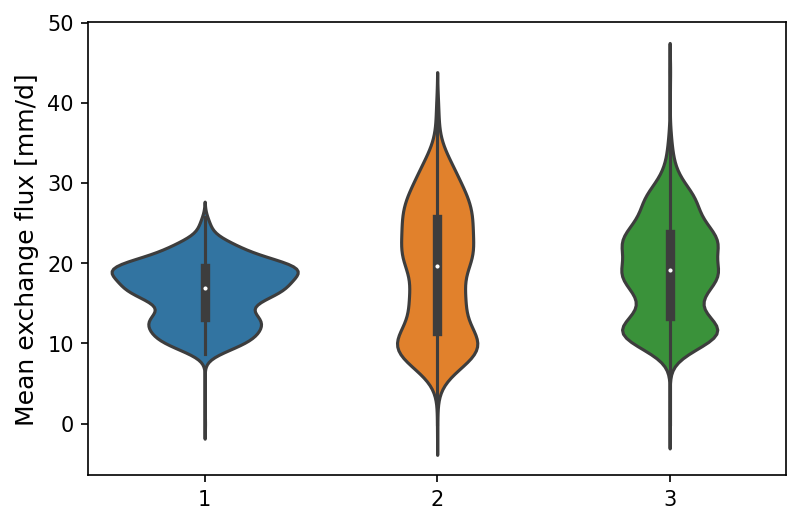

In [123]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_exchange_flux_streamOrder_violin.jpg", dpi=300)
plt.close(fig)  

In [124]:
df.to_csv(riverbed_dir + f"{icase}-exchange_flux-streamOrder.csv")

### Heat map across main stem (streamOrder=3)

In [27]:
river_tri = triangles[river_idx]

idx = riverbed_orders == 3
iflux = sub_data[:, idx]

river_tri_3rd = river_tri[idx]

In [28]:
river_bary = []
river_bary_p = []
for tri in river_tri_3rd:
    verts = surface_vertex_xyz[tri]
    bary = np.sum(np.array(verts), axis=0)/3    
    bary_p = shapely.geometry.Point(bary[0], bary[1])
    river_bary.append(bary)
    river_bary_p.append(bary_p)
    
river_bary = np.array(river_bary)
river_bary_p = np.array(river_bary_p)

<ipython-input-28-aae7848eede7>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  river_bary_p = np.array(river_bary_p)


In [29]:
outlet_idx = np.argmax(river_bary[:, 0])
outlet_bary = river_bary[outlet_idx]

outlet_bary_p = shapely.geometry.Point(outlet_bary[0], outlet_bary[1])

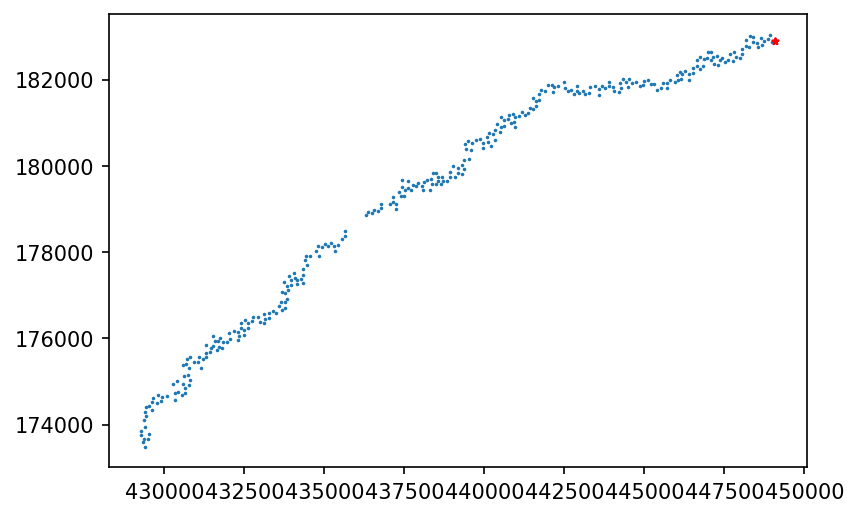

In [30]:
plt.scatter(river_bary[:,0], river_bary[:,1], s=0.5)
plt.scatter(outlet_bary[0], outlet_bary[1], s=10, color='r', marker = '*')

In [31]:
distances = []
for p in river_bary_p:
    idistance = p.distance(outlet_bary_p)
    distances.append(idistance)
    
distances = np.array(distances)

In [32]:
met_df = pd.read_csv(fname_water_balance, index_col=0, parse_dates=True)

In [33]:
colors = mcolors.colors('matplotlib')

In [39]:
import matplotlib.ticker as tck

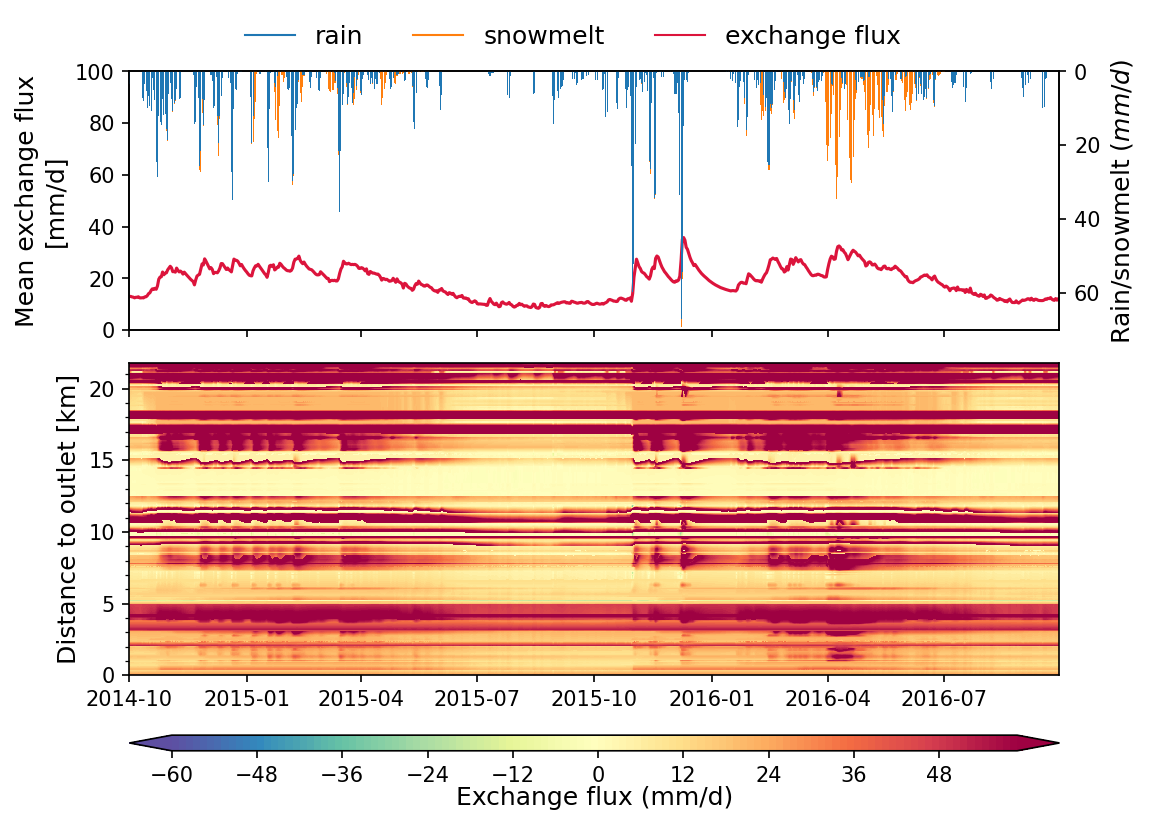

In [41]:
fig = plt.figure()

gs = gridspec.GridSpec(2, 1, height_ratios=[2,3])
gs.update(hspace = 0.1) # adjust vertical spacing b/w subplots
ax1 = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1], sharex=ax1)
ax2 = plt.subplot(gs[1])

# ax1.plot(data=met_df['watershed boundary discharge [m^3/d]'])
# met_df['watershed boundary discharge [m^3/d]'].plot(ax=ax1, color= 'darkslategray')
ax1.plot(t, mean_ponded_riverbed_flux, 'crimson', label = 'exchange flux')
ax1.set_ylim([0,100])
ylabel = '\n'.join(wrap("Mean exchange flux [mm/d]", 20))
ax1.set_ylabel(ylabel, fontsize=12)

ax11 = ax1.twinx()
ax11.bar(met_df.index, met_df["rain precipitation [mm d^-1]"], lw=1.5)
ax11.bar(met_df.index, met_df["snowmelt [mm d^-1]"], lw=1.5, bottom = met_df["rain precipitation [mm d^-1]"])
# river_middle_datum.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
ax11.set_ylim([0,70])
ax11.invert_yaxis()
ax11.set_ylabel('Rain/snowmelt ($mm/d$)', fontsize = 12)
ut.custom_legend(colors[:2] + ['crimson'], ['rain', 'snowmelt', 'exchange flux'], loc = 'lower left',  ax = ax1, 
                    bbox_to_anchor =(0.1 , 1.0), ncol = 3)
# ax1.tick_params(axis=u'x', which=u'minor',length=0)
ax1.set_xlim([datetime.datetime(2014,10,1), datetime.datetime(2016,9,30)])
ax1.set_xlabel('')
# ax1.get_xaxis().set_ticks([])
ax1.set_xticklabels([])

cf1 = ax2.contourf(t,
                   distances/1000,
                   iflux.transpose(),
                   cmap=plt.cm.Spectral_r,
                   levels=np.arange(-60, 60, 1),
                   extend="both",
                   )
# ylabel = '\n'.join(wrap("Distance to outlet (m)", 20))
ylabel = 'Distance to outlet [km]'
ax2.set_ylabel(ylabel, fontsize=12)
# ax2.tick_params(axis='y', which='minor', bottom=False)
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
# ax2.set_xticks(time_ticks)
# ax2.set_yticks(np.arange(0, 76, 10))
# ax2.set_ylim([0, 73])
ax2.set_xlim([datetime.datetime(2014,10,1), datetime.datetime(2016,9,30)])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=0.4, pack_start=True)
fig.add_axes(cax)
cb1 = fig.colorbar(cf1, cax=cax, orientation="horizontal")

# cb1 = plt.colorbar(cf1, extend="both", orientation = "horizontal", pad = 0.2)
cb1.ax.set_xlabel("Exchange flux (mm/d)", labelpad=0.3)

# ax1.minorticks_off()
fig.set_size_inches(8, 6)

In [42]:
fig.savefig(figure_dir + f"riverbed_study/{icase}_exchange_flux_heat_3rd_stream.jpg", dpi=300)
plt.close(fig)  

## riverbed ET

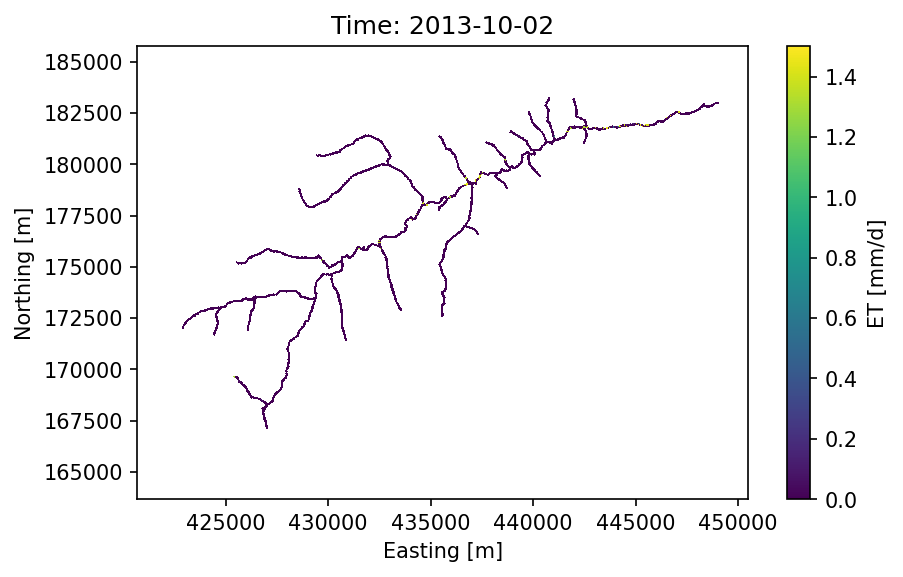

In [463]:
fig, ax = plt.subplots(1,1, figsize=(6.8,4))
ax, tpc = pv.plot_surface_data(surface_vis, surface_vertex_xyz, surface_conn, 
                                   var_name="surface-total_evapotranspiration", colorbar = True, 
                                   subset = True, subset_idx = new_river_idx, 
                               # cmap = 'seismic', 
                                     clabel = "ET [mm/d]",
                                   title = True, log = False, time_slice= 1, ax=ax)

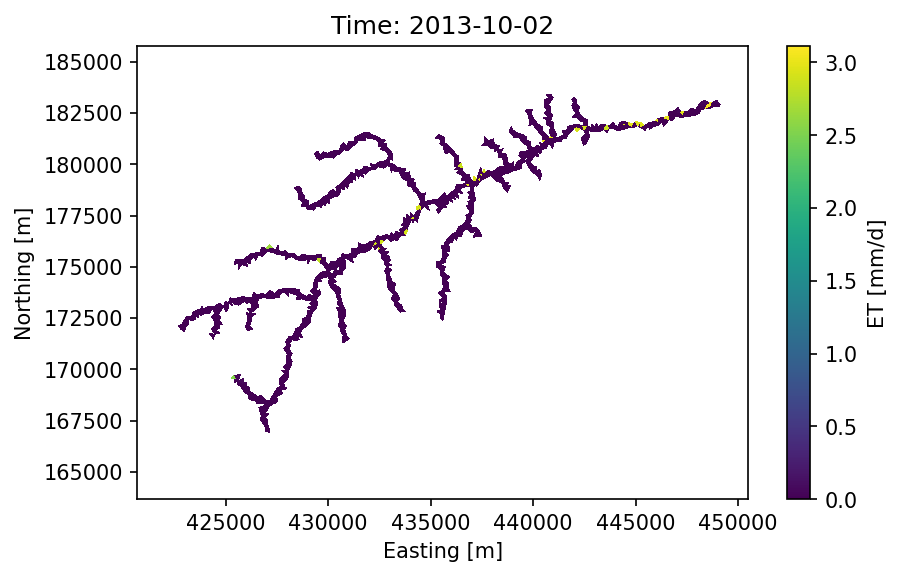

In [52]:
df_ET, _,_ = var_across_riverbed(surface_vis, "surface-total_evapotranspiration", river_idx)
df_E, _,_ = var_across_riverbed(surface_vis, "surface-evaporation", river_idx)
df_T, _,_ = var_across_riverbed(surface_vis, "surface-transpiration", river_idx)

df_ET.to_csv(fname_ET)
df_E.to_csv(fname_E)
df_T.to_csv(fname_T)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(t, df_ET['average [mm/d]'], 'crimson', label = 'ET')
ax.set_ylim([0,5])

ax1 = ax.twinx()
ax1.bar(df.index, df["rain precipitation [mm d^-1]"], lw=1.5)
ax1.bar(df.index, df["snowmelt [mm d^-1]"], lw=1.5, bottom = df["rain precipitation [mm d^-1]"])

ax1.set_ylim([0,70])
ax1.invert_yaxis()
ax1.set_ylabel('Rain/snowmelt ($mm/d$)', fontsize = 14)
ut.custom_legend(colors[:2], ['rain', 'snowmelt'], loc = 'lower left',  ax = ax1, 
                    bbox_to_anchor =(0.1 , 1.0), ncol = 2)
ax1.tick_params(axis=u'x', which=u'minor',length=0)

ax.set_xlim([datetime.datetime(2014,10,1), datetime.datetime(2016,9,30)])
ax.set_ylabel("ET across riverbed [mm/d]", fontsize=14)
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor =(0.5 , 1.13), ncol = 1)

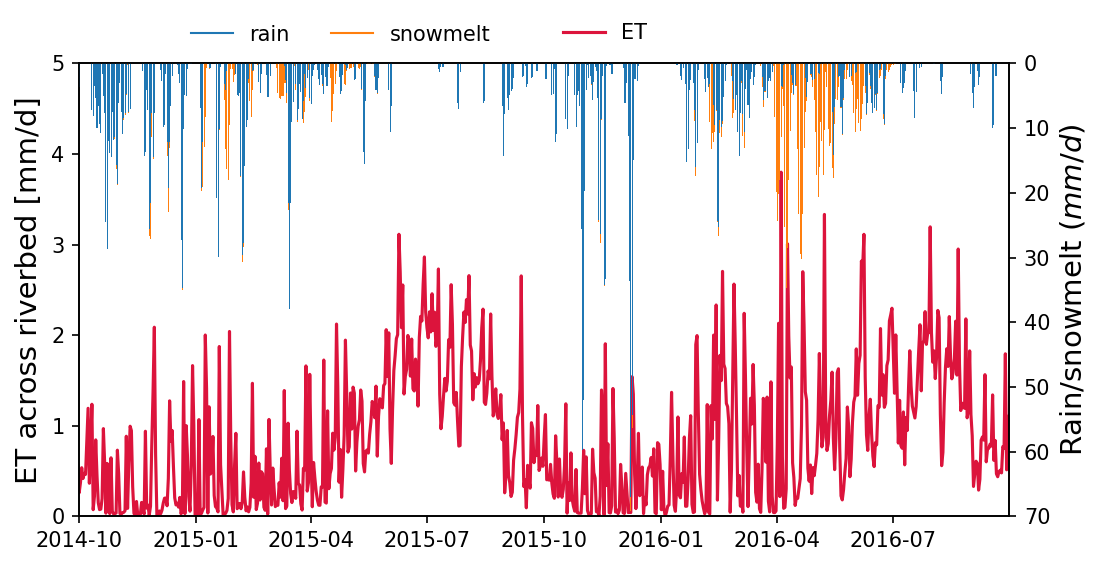

<AxesSubplot:xlabel='datetime'>

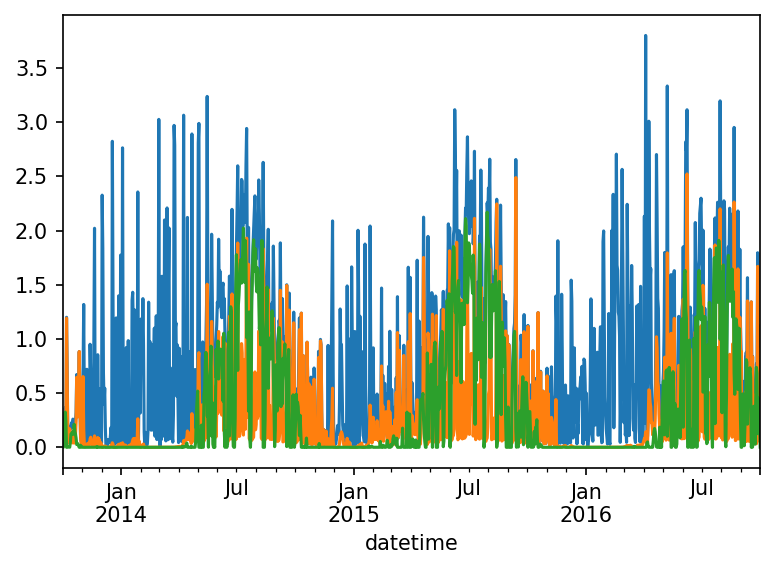

In [436]:
df_ET['average [mm/d]'].plot()
df_E['average [mm/d]'].plot()
df_T['average [mm/d]'].plot()

<AxesSubplot:xlabel='datetime'>

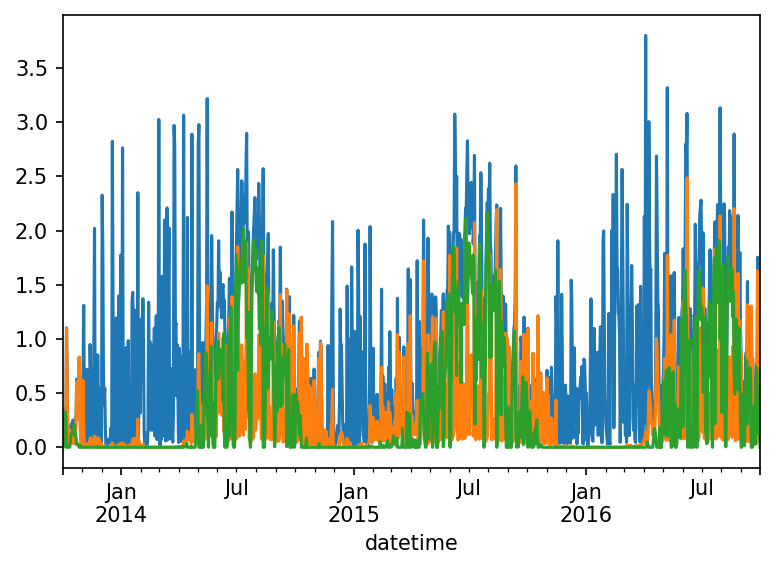

## compare with NEXSS

In [90]:
# df_ats =pd.read_csv(fname_riverbed_flux, index_col='datetime', parse_dates=True)
df_nexss = pd.read_csv(fname_nexss)

lat_flux = df_nexss.loc[:, 'qhef_lat_1':'qhef_lat_12'].dropna()
ver_flux = df_nexss.loc[:, 'qhef_ver_1':'qhef_ver_12'].dropna()

lat_flux = 10**lat_flux * 1000*86400 #convert log10-m/s to mm/d
ver_flux = 10**ver_flux * 1000*86400 #convert log10-m/s to mm/d

In [91]:
df_ats_ma = sub_data_df.groupby(pd.Grouper(freq='M')).mean()

df_ats_ma['month'] = df_ats_ma.index.month

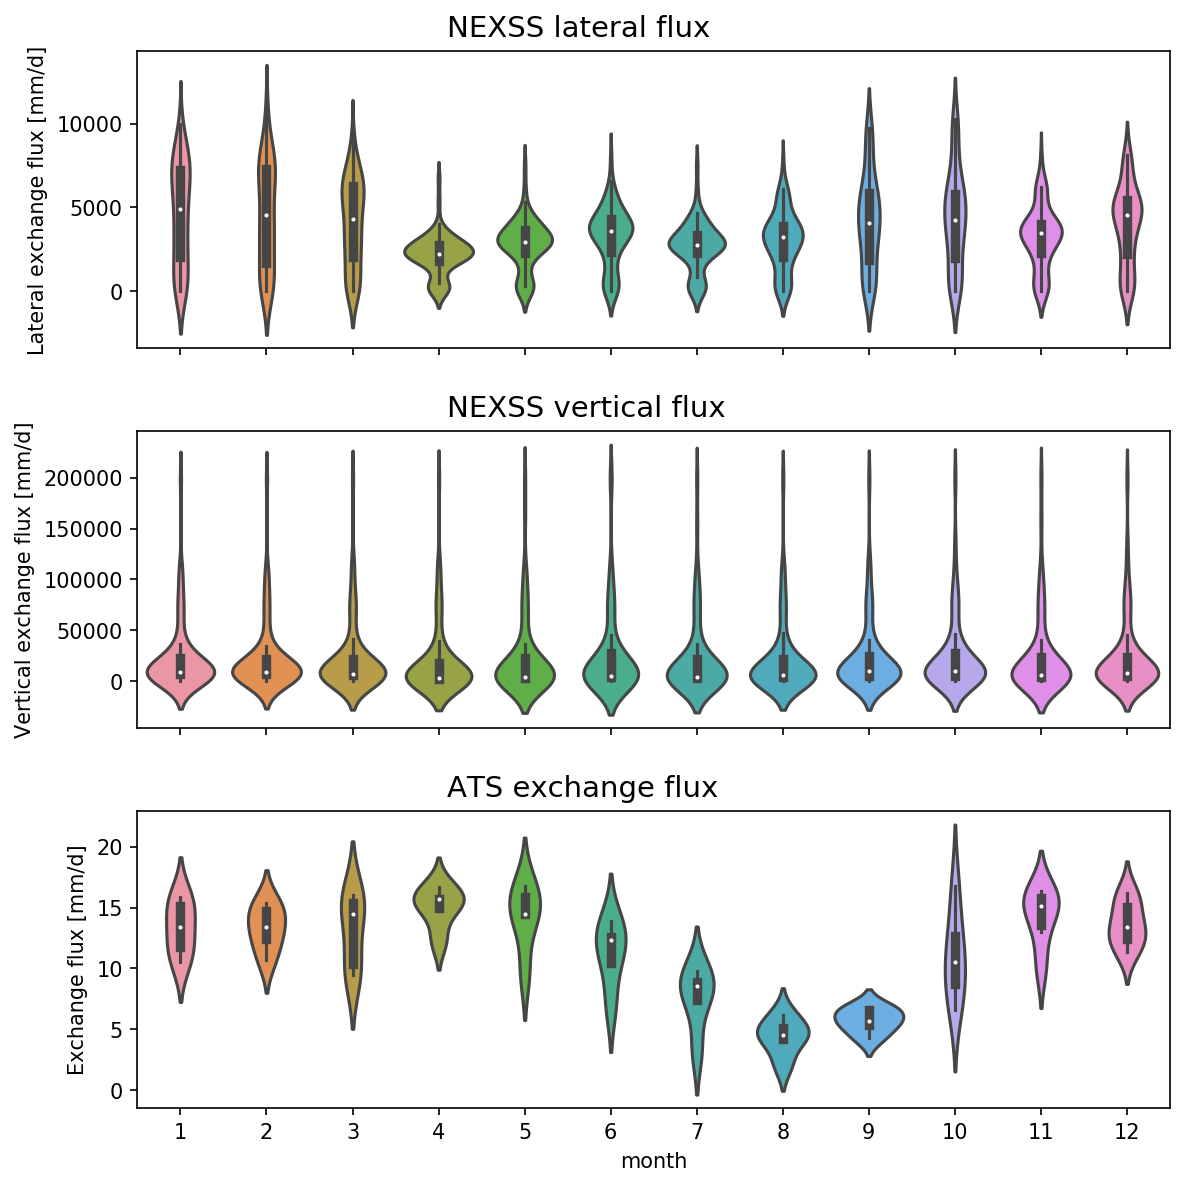

In [93]:
fig, axes = plt.subplots(3,1, figsize=(8,8))

ax=axes[0]
sns.violinplot(data = lat_flux, ax=ax)
ax.set_ylabel('Lateral exchange flux [mm/d]', fontsize=10)
ax.set_xticklabels([])
ax.text(0.3, 1.05, 'NEXSS lateral flux', fontsize = 14, transform = ax.transAxes)

ax=axes[1]
sns.violinplot(data = ver_flux, ax=ax)
ax.set_ylabel('Vertical exchange flux [mm/d]')
ax.set_xticklabels([])
ax.text(0.3, 1.05, 'NEXSS vertical flux', fontsize = 14, transform = ax.transAxes)

ax=axes[2]
sns.violinplot(x= 'month', y = 'average below water [mm/d]', data = df_ats_ma, ax=ax)
ax.set_ylabel('Exchange flux [mm/d]')

ax.text(0.3, 1.05, 'ATS exchange flux', fontsize = 14, transform = ax.transAxes)

fig.tight_layout()